In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# from pandas_profiling import ProfileReport # profile report を作る用
from matplotlib_venn import venn2 # venn図を作成する用

NOTEOOKNAME = 'baseline_nyk510_base_EX028'

sns.set_style('ticks')

INPUT_DIR = './data'
OUTPUT_DIR = './submission'

os.makedirs(OUTPUT_DIR, exist_ok=True)

train_df = pd.read_csv(os.path.join(INPUT_DIR, 'train.csv'))
test_df = pd.read_csv(os.path.join(INPUT_DIR, 'test.csv'))

# whole_df = pd.concat([train_df, test_df], ignore_index=True)

In [2]:
train_df.head().T

,0,1,2,3,4
Name,LEGO Batman: The Videogame,LEGO Indiana Jones: The Original Adventures,LEGO Batman: The Videogame,Combat,LEGO Harry Potter: Years 5-7
Platform,Wii,Wii,PSP,2600,Wii
Year_of_Release,NaN,NaN,NaN,NaN,NaN
Genre,Action,Action,Action,Action,Action
Publisher,Warner Bros. Interactive Entertainment,LucasArts,Warner Bros. Interactive Entertainment,Atari,Warner Bros. Interactive Entertainment
NA_Sales,180,151,56,117,69
EU_Sales,97,61,44,7,42
JP_Sales,0,0,0,0,0
Other_Sales,28,21,27,1,12
Global_Sales,306,234,128,125,124


In [3]:
train_df['Year_of_Release_Platform'] = train_df['Year_of_Release'].astype(str) + '_' + train_df['Platform']
test_df['Year_of_Release_Platform'] = test_df['Year_of_Release'].astype(str) + '_' +  test_df['Platform']

train_df['Year_of_Release_Genre'] = train_df['Year_of_Release'].astype(str) + ' ' + train_df['Genre'].astype(str)
test_df['Year_of_Release_Genre'] = test_df['Year_of_Release'].astype(str) + ' '+ test_df['Genre'].astype(str)

train_df['Year_of_Release_Platform_Genre'] = train_df['Year_of_Release'].astype(str) + '_' + train_df['Platform'] + ' ' + train_df['Genre'].astype(str)
test_df['Year_of_Release_Platform_Genre'] = test_df['Year_of_Release'].astype(str) + '_' +  test_df['Platform'] + ' ' + train_df['Genre'].astype(str)

train_df['Year_of_Release_Platform_Genre_Rating'] = train_df['Year_of_Release'].astype(str) + '_' + train_df['Platform'] + ' ' + train_df['Genre'].astype(str)  + ' ' + train_df['Rating'].astype(str)
test_df['Year_of_Release_Platform_Genre_Rating'] = test_df['Year_of_Release'].astype(str) + '_' +  test_df['Platform'] + ' ' + test_df['Genre'].astype(str) + ' ' + test_df['Rating'].astype(str)

train_df['Year_of_Release_Rating'] = train_df['Year_of_Release'].astype(str) + ' ' + train_df['Rating'].astype(str)
test_df['Year_of_Release_Rating'] = test_df['Year_of_Release'].astype(str) + ' '+ test_df['Rating'].astype(str)

train_df['Platform_Genre'] = train_df['Platform'].astype(str) + ' ' + train_df['Genre'].astype(str)
test_df['Platform_Genre'] = test_df['Platform'].astype(str) + ' '+ test_df['Genre'].astype(str)

train_df['Publisher_Genre'] = train_df['Publisher'].astype(str) + ' ' + train_df['Genre'].astype(str)
test_df['Publisher_Genre'] = test_df['Publisher'].astype(str) + ' '+ test_df['Genre'].astype(str)

In [4]:
whole_df = pd.concat([train_df, test_df], ignore_index=True)

# 特徴量作成用のクラス群

In [5]:
def preprocess(input_df: pd.DataFrame) -> pd.DataFrame:
    output_df = input_df.copy()
    
    idx_tbd = input_df['User_Score'] == 'tbd'
    output_df['User_Score_is_tbd'] = idx_tbd.astype(int)
    
    output_df['User_Score'] = input_df['User_Score'].replace('tbd', None).astype(float)
    return output_df

def create_continuous_features(input_df):
    input_df = preprocess(input_df)
    use_columns = [
        # 連続変数
        'Critic_Score',
        'Critic_Count', 
        'User_Score', 
        'User_Count',
        'Year_of_Release',
        'User_Score_is_tbd'
    ]
    return input_df[use_columns].copy()

In [6]:
assert len(create_continuous_features(train_df)) == len(train_df)

In [7]:
assert create_continuous_features(train_df.head()).equals(create_continuous_features(train_df.head()))

### Booleanの特徴量

特定の条件を満たしているかどうか, を表す特徴量です。例えばテキストカラムに特定の文字列が存在しているかどうか、などが該当します。

In [8]:
import re

def extract_brackets(text:str)->str:
    m = re.findall(r'\(.+?\)', text)
    
    # カッコ有無の確認
    if len(m) > 0:
        result = m[-1].strip('()')[:-1]
            
    else:
        result = ''
        
    result = result.replace('weekly', '').replace('higher', '').replace('old', '').replace('american', 'america').replace('us', 'america').replace(' ', '')
    
    return result

In [9]:
def create_boolean_feature(input_df):
    output_df = pd.DataFrame()
    
    developer_texts = [
        'japan', 'nintendo',
    ]
    
    name_texts = [
        'allregion', 'jp', 'butwrongsyste','america','other'
    ]
    
    for t in developer_texts:
        output_df[f'Developer_has_{t}'] = input_df['Developer'].fillna('').str.lower().str.contains(t).astype(int)
    
    for t in name_texts:
        output_df[f'Name_has_{t}'] = input_df['Name'].fillna('').str.lower().apply(extract_brackets).str.contains(t).astype(int)
        
    return output_df

In [10]:
create_boolean_feature(train_df).sum()

Developer_has_japan       23
Developer_has_nintendo    88
Name_has_allregion         1
Name_has_jp               54
Name_has_butwrongsyste     2
Name_has_america          18
Name_has_other             2
dtype: int64

In [11]:
class BaseBlock(object):
    def fit(self, input_df, y=None):
        return self.transform(input_df)
        
    def transform(self, input_df):
        raise NotImplementedError()

### CountEncoding

In [12]:
class CountEncodingBlock(BaseBlock):
    def __init__(self, column, whole_df: pd.DataFrame):
        self.column = column
        self.whole_df = whole_df

    def transform(self, input_df):
        output_df = pd.DataFrame()
        c = self.column
        
        vc = self.whole_df[c].value_counts()
        output_df[c] = input_df[c].map(vc)
        return output_df.add_prefix('CE_')

In [13]:
assert len(train_df) == len(CountEncodingBlock('Name', whole_df=whole_df).fit(train_df))

### OneHotEncoding

In [14]:
class OneHotBlock(BaseBlock):
    def __init__(self, column: str, count_limit: int):
        self.column = column
        self.cats_ = None
        self.count_limit = count_limit
        
    def fit(self, input_df, y=None):
        vc = input_df[self.column].dropna().value_counts()
        cats = vc[vc > self.count_limit].index
        self.cats_ = cats
        return self.transform(input_df)
    
    def transform(self, input_df):
        x = pd.Categorical(input_df[self.column], categories=self.cats_)
        out_df = pd.get_dummies(x, dummy_na=False)
        out_df.columns = out_df.columns.tolist()
        return out_df.add_prefix(f'OH_{self.column}=')

In [15]:
OneHotBlock('Platform', 30).fit(train_df).sum(axis=0)

OH_Platform=DS      1106
OH_Platform=PS2     1104
OH_Platform=Wii      645
OH_Platform=PS3      643
OH_Platform=PSP      642
OH_Platform=X360     588
OH_Platform=PS       512
OH_Platform=GBA      445
OH_Platform=PC       439
OH_Platform=XB       371
OH_Platform=3DS      270
OH_Platform=PSV      240
OH_Platform=GC       240
OH_Platform=PS4      206
OH_Platform=SNES     130
OH_Platform=SAT      129
OH_Platform=N64      125
OH_Platform=XOne     121
OH_Platform=2600      88
OH_Platform=WiiU      87
OH_Platform=GB        78
OH_Platform=NES       66
OH_Platform=DC        41
dtype: int64

### n-gram の特徴量への使い方

上位に属している組み合わせが存在するかどうかを 0-1 のフラグとして持つ方法があるでしょう。

In [16]:
import texthero as hero
from texthero import preprocessing
from nltk.util import ngrams

In [17]:
def clearn_by_hero(x):
    custom_pipeline = [preprocessing.fillna
                   , preprocessing.lowercase
                   , preprocessing.remove_digits
                   , preprocessing.remove_punctuation
                   , preprocessing.remove_diacritics
                   , preprocessing.remove_whitespace
                   , preprocessing.remove_stopwords
                  ]
    return hero.clean(x, custom_pipeline)

def line_ngram(line, n=2):
    words = [w for w in line.split(' ') if len(w) != 0] # 空文字は取り除く
    return list(ngrams(words, n))

def create_n_gram(x, n=3):
    x = clearn_by_hero(x)
    x = pd.Series(x).map(lambda r: line_ngram(r, n=n))
    return x

class NGramBlock(BaseBlock):
    def __init__(self, whole_df, column:str='Name', top_n:int=20, n=3):
        self.whole_df = whole_df
        self.column = column
        self.top_n = top_n
        self.n = n
    
    def fit(self, input_df, y=None):
        name_grams = create_n_gram(self.whole_df[self.column], n=self.n)
        grams = [x for row in name_grams for x in row if len(x) > 0]
        top_grams = pd.Series(grams).value_counts().head(self.top_n).index
        
        self.top_grams_ = top_grams
        return self.transform(input_df)
    
    def transform(self, input_df):
        name_grams = create_n_gram(input_df[self.column], n=self.n)
        output_df = pd.DataFrame()
        
        for top in self.top_grams_:
            s_top = '-'.join(top)
            output_df[f'{s_top}'] = name_grams.map(lambda x: top in x).map(int)

        return output_df.add_prefix(f'{self.column}_has_').add_suffix(f'_n={self.n}')

In [18]:
block = NGramBlock(train_df, column='Developer', top_n=20, n=3)
block.fit(train_df).head()

,Developer_has_high-voltage-software_n=3,Developer_has_harmonix-music-systems_n=3,Developer_has_artificial-mind-movement_n=3,Developer_has_eurocom-entertainment-software_n=3,Developer_has_san-diego-studios_n=3,Developer_has_scea-san-diego_n=3,Developer_has_arc-system-works_n=3,Developer_has_heavy-iron-studios_n=3,Developer_has_nippon-ichi-software_n=3,Developer_has_scee-london-studio_n=3,Developer_has_sce-japan-studio_n=3,Developer_has_rockstar-san-diego_n=3,Developer_has_blue-castle-games_n=3,Developer_has_take-two-interactive_n=3,Developer_has_monkey-bar-games_n=3,Developer_has_black-lantern-studios_n=3,Developer_has_double-helix-games_n=3,Developer_has_microsoft-game-studios_n=3,Developer_has_koei-tecmo-games_n=3,Developer_has_namco-bandai-games_n=3
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
block.transform(test_df).sum()

Developer_has_high-voltage-software_n=3             10
Developer_has_harmonix-music-systems_n=3            15
Developer_has_artificial-mind-movement_n=3          27
Developer_has_eurocom-entertainment-software_n=3    14
Developer_has_san-diego-studios_n=3                  0
Developer_has_scea-san-diego_n=3                     0
Developer_has_arc-system-works_n=3                  22
Developer_has_heavy-iron-studios_n=3                 2
Developer_has_nippon-ichi-software_n=3               0
Developer_has_scee-london-studio_n=3                 0
Developer_has_sce-japan-studio_n=3                   0
Developer_has_rockstar-san-diego_n=3                 1
Developer_has_blue-castle-games_n=3                  0
Developer_has_take-two-interactive_n=3               0
Developer_has_monkey-bar-games_n=3                   5
Developer_has_black-lantern-studios_n=3             14
Developer_has_double-helix-games_n=3                 9
Developer_has_microsoft-game-studios_n=3             1
Developer_

### 名前の類似度と距離（使っていない）

In [20]:
from typing import List
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.decomposition import TruncatedSVD
import re
import string
from sklearn.cluster import KMeans

In [21]:
def tokenize(text: str) -> List[str]:
    """記号を分離して、文章を単語ごとに分割する関数
    """
    re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
    return re_tok.sub(r' \1 ', text).split()

def create_tf_idf(x, n):
    tfidf = TfidfVectorizer(
        ngram_range=(2, n),  # bi-gram まで考慮
        tokenizer=tokenize,  # 文章の分割のアルゴリズム
        min_df=3,  # 最低でも3つの文章に出現するものに限定する
        max_df=0.8,  # 全体の80%以下の文章に出現するものに限定する
        sublinear_tf=True  # カウントに log スケールをかける
    )
    
    tfidf.fit(x.fillna('unknown'))
    return tfidf

def change_dim(matrix, dim):
    svd_ = TruncatedSVD(n_components=dim, random_state=1337)
    svd_.fit(matrix)
    return svd_

class TF_IDF_DIST_Block(BaseBlock):
    def __init__(self, column:str='Name', weight_column:str='Global_Sales', n=3, dim=24, n_clusters=20):
        self.column = column
        self.n = n
        self.dim = dim
        self.weight_column = weight_column
        self.n_clusters = n_clusters
    
    def fit(self, input_df):
        # 文字列のベクトル化・次元削減
        self.tfidf = create_tf_idf(input_df[self.column], self.n)
        matrix = self.tfidf.transform(input_df[self.column].fillna('Unknown'))
        self.svd = change_dim(matrix, self.dim)
        matrix = self.svd.transform(matrix)

        # 各クラスタの中心からの距離
        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=20)
        self.kmeans.fit(matrix, sample_weight=np.log1p(input_df[self.weight_column]))
        distance_from_clusters = pd.DataFrame(self.kmeans.transform(matrix))
        
        return distance_from_clusters.add_prefix(f'DIST_{self.column}_').add_suffix(f'_{self.weight_column}')
    
    def transform(self, input_df):
        matrix = self.tfidf.transform(input_df[self.column].fillna('Unknown'))
        matrix = self.svd.transform(matrix)
        distance_from_clusters = pd.DataFrame(self.kmeans.transform(matrix))
        return distance_from_clusters.add_prefix(f'DIST_{self.column}_').add_suffix(f'_{self.weight_column}')

In [22]:
block = TF_IDF_DIST_Block()
assert block.fit(train_df).head().equals(block.transform(train_df).head())
display( block.fit(train_df).head())

C:\Users\akira.shirahama\Anaconda3\envs\kaggle_workspace\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
C:\Users\akira.shirahama\Anaconda3\envs\kaggle_workspace\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


,DIST_Name_0_Global_Sales,DIST_Name_1_Global_Sales,DIST_Name_2_Global_Sales,DIST_Name_3_Global_Sales,DIST_Name_4_Global_Sales,DIST_Name_5_Global_Sales,DIST_Name_6_Global_Sales,DIST_Name_7_Global_Sales,DIST_Name_8_Global_Sales,DIST_Name_9_Global_Sales,DIST_Name_10_Global_Sales,DIST_Name_11_Global_Sales,DIST_Name_12_Global_Sales,DIST_Name_13_Global_Sales,DIST_Name_14_Global_Sales,DIST_Name_15_Global_Sales,DIST_Name_16_Global_Sales,DIST_Name_17_Global_Sales,DIST_Name_18_Global_Sales,DIST_Name_19_Global_Sales
0,0.276188,0.136293,0.400109,1.033808,0.621597,0.852616,0.880372,0.728274,0.614397,0.766710,0.653906,0.572631,0.791250,0.815299,0.838854,0.567802,0.892429,0.400221,0.660726,0.700522
1,0.156973,0.184952,0.333580,1.006428,0.578811,0.821164,0.843126,0.696667,0.562225,0.733313,0.620362,0.534496,0.739493,0.781980,0.817788,0.500980,0.869291,0.327676,0.594922,0.695144
2,0.276188,0.136293,0.400109,1.033808,0.621597,0.852616,0.880372,0.728274,0.614397,0.766710,0.653906,0.572631,0.791250,0.815299,0.838854,0.567802,0.892429,0.400221,0.660726,0.700522
3,0.010477,0.338387,0.296533,0.994020,0.558334,0.805634,0.828501,0.684895,0.573447,0.716146,0.603749,0.516779,0.717287,0.767971,0.802154,0.476034,0.854625,0.295875,0.580495,0.678907
4,0.063352,0.346730,0.303543,0.996263,0.562640,0.808136,0.830943,0.686915,0.578704,0.719415,0.605127,0.520460,0.721955,0.767337,0.795058,0.480169,0.858218,0.304162,0.584153,0.694697


### 同一Name、且つYear_of_ReleaseがNAの場合最頻値で埋める

In [23]:
def get_mode(x):
    if len(x.dropna()) > 2:
        if len(x.dropna().mode()) > 1:
            result = np.full(len(x), x.dropna().mode()[0])
        else:
            result = np.full(len(x), x.dropna().mode())
    else:
        result = x
    
    return result

class FillNaOfYearOfReleaseBlock(BaseBlock):
    def __init__(self, whole_df):
        self.whole_df = whole_df.copy()
    
    def fit(self, input_df):
        return self.transform(input_df)
    
    def transform(self, input_df):
        out_df = input_df.copy()
        out_df = out_df[['Name', 'Year_of_Release']]
        out_df['Is_Null_Year'] = out_df['Year_of_Release'].isnull()
        out_df['Name'] = out_df['Name'].fillna('unknown')
        out_df['Replace_Year'] = out_df.groupby('Name')['Year_of_Release'].transform(get_mode)
        out_df.loc[out_df['Is_Null_Year'], 'Year_of_Release'] = out_df.loc[out_df['Is_Null_Year'], 'Replace_Year']
        return out_df['Replace_Year']

In [24]:
block = FillNaOfYearOfReleaseBlock(whole_df)
assert block.fit(train_df).head().equals(block.transform(train_df).head())
display(block.fit(train_df.head()))

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: Replace_Year, dtype: float64

### 売り上げポートフォリオ

In [25]:
sales_columns = train_df.columns[train_df.columns.str.contains('Sales')].tolist()
sales_columns = sorted(sales_columns)

In [26]:
class SalesPortfolioBlock(BaseBlock):
    """売上ポートフォリオ"""
    
    def __init__(self, key: str):
        self.key = key    
        self.meta_df = None
    
    def fit(self, input_df):
        _df = input_df[sales_columns].groupby(input_df[self.key]).sum()
        _df = (_df.T / _df.sum(axis=1)).T
        self.meta_df = _df
        return self.transform(input_df)
    
    def transform(self, input_df):
        out_df = pd.merge(input_df[self.key], self.meta_df, on=self.key, how='left').drop(columns=[self.key])
        out_df = out_df.add_prefix(f'SP@{self.key}_')
        return out_df

In [27]:
block = SalesPortfolioBlock('Genre')
assert len(block.fit(train_df)) == len(train_df)
display(block.fit(train_df.head()))

,SP@Genre_EU_Sales,SP@Genre_Global_Sales,SP@Genre_JP_Sales,SP@Genre_NA_Sales,SP@Genre_Other_Sales
0,0.137158,0.501093,0.0,0.313115,0.048634
1,0.137158,0.501093,0.0,0.313115,0.048634
2,0.137158,0.501093,0.0,0.313115,0.048634
3,0.137158,0.501093,0.0,0.313115,0.048634
4,0.137158,0.501093,0.0,0.313115,0.048634


In [28]:
class WrapperBlock(BaseBlock):
    def __init__(self, function):
        self.function = function
        
    def transform(self, input_df):
        return self.function(input_df)

### Target Encoding（使っていない）

In [29]:
from sklearn.model_selection import KFold

class TargetEnodingBlock(BaseBlock):
    def __init__(self, column:str='Genre', target_column:str='Global_Sales', agg_funcs:str=['mean', 'var', 'min', 'max']):
        self.column = column
        self.target_column = target_column
        self.agg_funcs = agg_funcs

    def fit(self, input_df):
        self.target_map = input_df.groupby(self.column)[self.target_column].agg(self.agg_funcs)
        
        output_encoded = np.zeros((len(input_df), len(self.agg_funcs)))
        kf = KFold(n_splits=4, shuffle=True, random_state=1000)
        for index, agg_func in enumerate(self.agg_funcs):
            for train_idx, valid_idx in kf.split(input_df):
                target_map = input_df.iloc[train_idx].groupby(self.column)[self.target_column].agg(self.agg_funcs)
                output_encoded[valid_idx, index] = input_df.iloc[valid_idx][self.column].map(target_map[agg_func].to_dict())
        
        output_encoded = pd.DataFrame(output_encoded)
        output_encoded.columns = [f'TE_{self.column}_{self.target_column}_{agg_func}' for agg_func in self.agg_funcs]
        return output_encoded
    
    def transform(self, input_df):
        output_encoded = np.zeros((len(input_df), len(self.agg_funcs)))
        for index, agg_func in enumerate(self.agg_funcs):        
            output_encoded[:,index] = input_df[self.column].map(self.target_map['mean'].to_dict()).values
            
        output_encoded = pd.DataFrame(output_encoded)
        output_encoded.columns = [f'TE_{self.column}_{self.target_column}_{agg_func}' for agg_func in self.agg_funcs]
        return output_encoded

In [30]:
block = TargetEnodingBlock()
assert len(block.fit(train_df)) == len(train_df)
display( block.fit(train_df).head())

,TE_Genre_Global_Sales_mean,TE_Genre_Global_Sales_var,TE_Genre_Global_Sales_min,TE_Genre_Global_Sales_max
0,61.443615,21100.293343,1.0,2104.0
1,62.091183,18410.846129,1.0,2081.0
2,59.647522,17517.466212,1.0,2104.0
3,60.796440,20443.688198,1.0,2104.0
4,61.443615,21100.293343,1.0,2104.0


### Publisherごとの各要素のカウント

In [31]:
class PublisherCountBlock(BaseBlock):
    def __init__(self, whole_df, column:str='Platform'):
        self.column = column
        self.whole_df = whole_df

    def fit(self, input_df):
        self.publisher_pivot_df = self.whole_df.pivot_table(index='Publisher', columns=self.column, values='Name', aggfunc='count').reset_index().fillna(0)
        out_df = pd.merge(input_df['Publisher'], self.publisher_pivot_df, on='Publisher', how='left').drop(columns=['Publisher'])
        out_df = out_df.add_prefix(f'SP@{self.column}_')
        return out_df
    
    def transform(self, input_df):
        out_df = pd.merge(input_df['Publisher'], self.publisher_pivot_df, on='Publisher', how='left').drop(columns=['Publisher'])
        out_df = out_df.add_prefix(f'PG@{self.column}_')
        return out_df

In [32]:
block = PublisherCountBlock(whole_df)
assert len(block.fit(train_df)) == len(train_df)
display( block.fit(train_df).head())

,SP@Platform_2600,SP@Platform_3DO,SP@Platform_3DS,SP@Platform_DC,SP@Platform_DS,SP@Platform_GB,SP@Platform_GBA,SP@Platform_GC,SP@Platform_GEN,SP@Platform_GG,...,SP@Platform_SAT,SP@Platform_SCD,SP@Platform_SNES,SP@Platform_TG16,SP@Platform_WS,SP@Platform_Wii,SP@Platform_WiiU,SP@Platform_X360,SP@Platform_XB,SP@Platform_XOne
0,0.0,0.0,18.0,0.0,32.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,24.0,15.0,34.0,0.0,14.0
1,0.0,0.0,1.0,0.0,9.0,0.0,1.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,8.0,0.0,8.0,8.0,0.0
2,0.0,0.0,18.0,0.0,32.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,24.0,15.0,34.0,0.0,14.0
3,54.0,0.0,1.0,0.0,36.0,0.0,44.0,18.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,24.0,0.0,20.0,37.0,2.0
4,0.0,0.0,18.0,0.0,32.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,24.0,15.0,34.0,0.0,14.0


### Developerを分解してOne-Hot-Encoding（使っていない）

In [33]:
import itertools
from sklearn.preprocessing import MultiLabelBinarizer

class DeveloperOHBlock(BaseBlock):
    def __init__(self, whole_df, min_count=20):
        self.whole_df = whole_df
        self.min_count = min_count
    
    def fit(self, input_df):
        self.whole_df['Developer_S'] = self.whole_df['Developer'].str.split(', ')
        whole_developers = pd.Series(list(itertools.chain.from_iterable(self.whole_df['Developer_S'].fillna('').values)))
        whole_developers = whole_developers.value_counts()
        all_developers = whole_developers[whole_developers > self.min_count].index
        
        self.mlb = MultiLabelBinarizer()
        self.mlb.fit([list(all_developers)])
        
        temp_df = input_df.copy()
        temp_df['Developer_S'] = temp_df['Developer'].str.split(', ')
        out_df = pd.DataFrame(self.mlb.transform(temp_df['Developer_S'].fillna('').values), columns=self.mlb.classes_).add_prefix('Developer_Count_')
        return out_df
    
    def transform(self, input_df):
        temp_df = input_df.copy()
        temp_df['Developer_S'] = temp_df['Developer'].str.split(', ')
        out_df = pd.DataFrame(self.mlb.transform(temp_df['Developer_S'].fillna('').values), columns=self.mlb.classes_).add_prefix('Developer_Count_')
        return out_df

In [34]:
block = DeveloperOHBlock(whole_df)
assert len(block.fit(train_df)) == len(train_df)
display( block.fit(train_df).head())

C:\Users\akira.shirahama\Anaconda3\envs\kaggle_workspace\lib\site-packages\sklearn\preprocessing\_label.py:994: UserWarning: unknown class(es) ['10tacle Studios', '1C', '1C Company', '1C:Ino-Co', '1st Playable Productions', '2015', '2D Boy', '2K Australia', '2K Czech', '2K Games', '2K Marin', '2K Play', '2K Shanghai', '2K Sports', '2XL Games', '343 Industries', '3D Realms', '3DO', '3G Studios', '3d6 Games', '49Games', '4A Games', '4J Studios', '5TH Cell', '5pb', '7 Studios', '777 Studios', '8Monkey Labs', '8ing/Raizing', 'AI', 'AQ Interactive', 'AWE Games', 'Access Games', 'Acquire', 'Activision Value', 'Adrenium', 'Agatsuma Entertainment', 'Agenda', 'Airtight Games', 'Akella', 'Alawar Entertainment', 'Alfa System', 'Alphadream Corporation', 'Alternative Software', 'Ambrella', 'Amedio', 'Amusement Vision', 'Amuze', 'Anchor', 'Angel Studios', 'Anino Entertainment', 'ApolloSoft', 'Appaloosa Interactive', 'Aqua Pacific', 'Aqua Plus', 'Arcade Moon', 'Argonaut Games', 'Arika', 'Arkane Studi

,Developer_Count_505 Games,Developer_Count_989 Sports,Developer_Count_Acclaim,Developer_Count_Activision,Developer_Count_Altron,Developer_Count_Amaze Entertainment,Developer_Count_Arc System Works,Developer_Count_Artificial Mind and Movement,Developer_Count_Atlus,Developer_Count_Avalanche Software,...,Developer_Count_Ubisoft Paris,Developer_Count_Ubisoft Shanghai,Developer_Count_Vicarious Visions,Developer_Count_Vicious Cycle,Developer_Count_Virtuos,Developer_Count_Visual Concepts,Developer_Count_Volition Inc.,Developer_Count_WayForward,Developer_Count_Yuke's,Developer_Count_n-Space
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Developerを分解してOne-Hot-Encodingした上でKMeans（使っていない）

In [35]:
class DeveloperOHDistBlock(BaseBlock):
    def __init__(self, whole_df, weight_column:str='Global_Sales', min_count=20, n_clusters=20):
        self.whole_df = whole_df
        self.weight_column = weight_column
        self.min_count = min_count
        self.n_clusters = n_clusters
    
    def fit(self, input_df):
        self.whole_df['Developer_S'] = self.whole_df['Developer'].str.split(', ')
        whole_developers = pd.Series(list(itertools.chain.from_iterable(self.whole_df['Developer_S'].fillna('').values)))
        whole_developers = whole_developers.value_counts()
        all_developers = whole_developers[whole_developers > self.min_count].index
        
        self.mlb = MultiLabelBinarizer()
        self.mlb.fit([list(all_developers)])
        
        temp_df = input_df.copy()
        temp_df['Developer_S'] = temp_df['Developer'].str.split(', ')
        matrix = self.mlb.transform(temp_df['Developer_S'].fillna('').values)

        # 各クラスタの中心からの距離
        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=20)
        self.kmeans.fit(matrix, sample_weight=np.log1p(input_df[self.weight_column]))
        distance_from_clusters = pd.DataFrame(self.kmeans.transform(matrix))
        
        return distance_from_clusters.add_prefix('DeveloperOH_').add_suffix(f'_{self.weight_column}')
    
    def transform(self, input_df):
        temp_df = input_df.copy()
        temp_df['Developer_S'] = temp_df['Developer'].str.split(', ')
        matrix = self.mlb.transform(temp_df['Developer_S'].fillna('').values)

        # 各クラスタの中心からの距離
        distance_from_clusters = pd.DataFrame(self.kmeans.transform(matrix))
        
        return distance_from_clusters.add_prefix('DeveloperOH_').add_suffix(f'_{self.weight_column}')

In [36]:
block = DeveloperOHDistBlock(whole_df)
assert len(block.fit(train_df)) == len(train_df)
display( block.fit(train_df).head())

C:\Users\akira.shirahama\Anaconda3\envs\kaggle_workspace\lib\site-packages\sklearn\preprocessing\_label.py:994: UserWarning: unknown class(es) ['10tacle Studios', '1C', '1C Company', '1C:Ino-Co', '1st Playable Productions', '2015', '2D Boy', '2K Australia', '2K Czech', '2K Games', '2K Marin', '2K Play', '2K Shanghai', '2K Sports', '2XL Games', '343 Industries', '3D Realms', '3DO', '3G Studios', '3d6 Games', '49Games', '4A Games', '4J Studios', '5TH Cell', '5pb', '7 Studios', '777 Studios', '8Monkey Labs', '8ing/Raizing', 'AI', 'AQ Interactive', 'AWE Games', 'Access Games', 'Acquire', 'Activision Value', 'Adrenium', 'Agatsuma Entertainment', 'Agenda', 'Airtight Games', 'Akella', 'Alawar Entertainment', 'Alfa System', 'Alphadream Corporation', 'Alternative Software', 'Ambrella', 'Amedio', 'Amusement Vision', 'Amuze', 'Anchor', 'Angel Studios', 'Anino Entertainment', 'ApolloSoft', 'Appaloosa Interactive', 'Aqua Pacific', 'Aqua Plus', 'Arcade Moon', 'Argonaut Games', 'Arika', 'Arkane Studi

C:\Users\akira.shirahama\Anaconda3\envs\kaggle_workspace\lib\site-packages\sklearn\preprocessing\_label.py:994: UserWarning: unknown class(es) ['10tacle Studios', '1C', '1C Company', '1C:Ino-Co', '1st Playable Productions', '2015', '2D Boy', '2K Australia', '2K Czech', '2K Games', '2K Marin', '2K Play', '2K Shanghai', '2K Sports', '2XL Games', '343 Industries', '3D Realms', '3DO', '3G Studios', '3d6 Games', '49Games', '4A Games', '4J Studios', '5TH Cell', '5pb', '7 Studios', '777 Studios', '8Monkey Labs', '8ing/Raizing', 'AI', 'AQ Interactive', 'AWE Games', 'Access Games', 'Acquire', 'Activision Value', 'Adrenium', 'Agatsuma Entertainment', 'Agenda', 'Airtight Games', 'Akella', 'Alawar Entertainment', 'Alfa System', 'Alphadream Corporation', 'Alternative Software', 'Ambrella', 'Amedio', 'Amusement Vision', 'Amuze', 'Anchor', 'Angel Studios', 'Anino Entertainment', 'ApolloSoft', 'Appaloosa Interactive', 'Aqua Pacific', 'Aqua Plus', 'Arcade Moon', 'Argonaut Games', 'Arika', 'Arkane Studi

,DeveloperOH_0_Global_Sales,DeveloperOH_1_Global_Sales,DeveloperOH_2_Global_Sales,DeveloperOH_3_Global_Sales,DeveloperOH_4_Global_Sales,DeveloperOH_5_Global_Sales,DeveloperOH_6_Global_Sales,DeveloperOH_7_Global_Sales,DeveloperOH_8_Global_Sales,DeveloperOH_9_Global_Sales,DeveloperOH_10_Global_Sales,DeveloperOH_11_Global_Sales,DeveloperOH_12_Global_Sales,DeveloperOH_13_Global_Sales,DeveloperOH_14_Global_Sales,DeveloperOH_15_Global_Sales,DeveloperOH_16_Global_Sales,DeveloperOH_17_Global_Sales,DeveloperOH_18_Global_Sales,DeveloperOH_19_Global_Sales
0,1.000204,1.416412,1.414425,1.414455,1.414272,1.414333,1.414214,1.414335,1.414214,1.414214,1.415682,0.0,1.414434,1.414214,1.414616,1.414214,1.414214,1.414214,1.414214,1.414214
1,1.000204,1.416412,1.414425,1.414455,1.414272,1.414333,1.414214,1.414335,1.414214,1.414214,1.415682,0.0,1.414434,1.414214,1.414616,1.414214,1.414214,1.414214,1.414214,1.414214
2,1.000204,1.416412,1.414425,1.414455,1.414272,1.414333,1.414214,1.414335,1.414214,1.414214,1.415682,0.0,1.414434,1.414214,1.414616,1.414214,1.414214,1.414214,1.414214,1.414214
3,0.020202,1.003106,1.000299,1.000341,1.000083,1.000169,1.000000,1.000171,1.000000,1.000000,1.002076,1.0,1.000312,1.000000,1.000570,1.000000,1.000000,1.000000,1.000000,1.000000
4,1.000204,1.416412,1.414425,1.414455,1.414272,1.414333,1.414214,1.414335,1.414214,1.414214,1.415682,0.0,1.414434,1.414214,1.414616,1.414214,1.414214,1.414214,1.414214,1.414214


### Developerを分解してカウント（使っていない）

In [37]:
class SplitedCountBlock(BaseBlock): 
    def __init__(self, column:str='Developer', split:str=', '):
        self.column = column
        self.split = split
        
    def fit(self, input_df):
        out_df = input_df.copy()
        out_df[f'Split_Count_{self.column}'] = out_df[self.column].fillna('[unknown]').apply(len)
        return out_df[f'Split_Count_{self.column}']
    
    def transform(self, input_df):
        out_df = input_df.copy()
        out_df[f'Split_Count_{self.column}'] = out_df[self.column].fillna('[unknown]').apply(len)
        return out_df[f'Split_Count_{self.column}']

In [38]:
block = SplitedCountBlock()
assert len(block.fit(train_df)) == len(train_df)
display( block.fit(train_df).sort_values().tail())

3625    49
7952    59
7953    59
6691    60
5127    80
Name: Split_Count_Developer, dtype: int64

### 集計

In [39]:
class AggregateBlock(BaseBlock):
    def __init__(self, whole_df, key:str, agg_column:str, agg_funcs:List[str]=['mean'], fill_na=None):
        self.whole_df = whole_df.copy()
        self.key = key
        self.agg_column = agg_column
        self.agg_funcs = agg_funcs
        self.fill_na = fill_na
    
    def fit(self, input_df):
        if self.fill_na:
            self.whole_df[self.agg_column] = self.whole_df[self.agg_column].fillna(fill_na)
        
        self.gp_df = self.whole_df.groupby(self.key).agg({self.agg_column: self.agg_funcs}).reset_index()
        column_names = [ f'GP_{self.agg_column}@{self.key}_{agg_func}' for agg_func in self.agg_funcs]
        self.gp_df.columns = [self.key] + column_names
        out_df = pd.merge(input_df[self.key], self.gp_df, on=self.key, how='left').drop(columns=[self.key])
        return out_df
        
    def transform(self, input_df):
        out_df = pd.merge(input_df[self.key], self.gp_df, on=self.key, how='left').drop(columns=[self.key])
        return out_df

In [40]:
block = AggregateBlock(whole_df, key='Rating', agg_column='User_Count', agg_funcs=['mean'])
assert len(block.fit(train_df)) == len(train_df)
display( block.fit(train_df).head())

,GP_User_Count@Rating_mean
0,79.853308
1,79.853308
2,79.853308
3,NaN
4,79.853308


### Shiftした特徴量の作成

In [41]:
class ShiftBlock(BaseBlock):
    def __init__(self, key:str, target_column:str, shift:int):
        self.key = key
        self.target_column = target_column
        self.shift = shift
    
    def fit(self, input_df):
        return self.transform(input_df)
        
    def transform(self, input_df):
        out_df = input_df.copy()
        out_df[self.key] = out_df[self.key].fillna('unknown')
        out_df[f'Shift{self.shift}_{self.target_column}@{self.key}'] = out_df.groupby(self.key)[self.target_column].transform(lambda x: x.shift(self.shift))
        return out_df[f'Shift{self.shift}_{self.target_column}@{self.key}']

In [42]:
block = ShiftBlock(key='Publisher', target_column='Year_of_Release', shift=-1)
assert len(block.fit(train_df)) == len(train_df)
display( block.fit(train_df).head())

0       NaN
1    1994.0
2       NaN
3       NaN
4       NaN
Name: Shift-1_Year_of_Release@Publisher, dtype: float64

### 特定カラム同士の四則演算

In [43]:
class ArithmeticOperationBlock(BaseBlock):
    def __init__(self, target_columns1:str, target_columns2:str, operation:str):
        self.target_columns1 = target_columns1
        self.target_columns2 = target_columns2
        self.operation = operation
    
    def fit(self, input_df):
        return self.transform(input_df)
    
    def transform(self, input_df):
        out_df = input_df.copy()
        out_column_name = f'{self.target_columns1}{self.operation}{self.target_columns2}'
        
        if self.operation == '+':
            out_df[out_column_name] = out_df[self.target_columns1] + out_df[self.target_columns2]
        elif self.operation == '-':
            out_df[out_column_name] = out_df[self.target_columns1] - out_df[self.target_columns2]
        elif self.operation == '*':
            out_df[out_column_name] = out_df[self.target_columns1] * out_df[self.target_columns2]
        elif self.operation == '/':
            out_df[out_column_name] = out_df[self.target_columns1] / out_df[self.target_columns2]
            
        return out_df[out_column_name]

In [44]:
block = ArithmeticOperationBlock('Global_Sales','JP_Sales', '-')
assert len(block.fit(train_df)) == len(train_df)
display( block.fit(train_df).head())

0    306
1    234
2    128
3    125
4    124
Name: Global_Sales-JP_Sales, dtype: int64

### 類似する名前でグルーピング
name_group_dictを作るのがそこそこ時間かかるので、できたらdumpしておく

In [45]:
import pickle

In [46]:
# from textdistance import jaro
# game_names = whole_df.sort_values('Year_of_Release')['Name'].unique()
# name_group_dict = {k : -1 for k in game_names} 
# class_num = 0

# for name in game_names:
#     results = np.array([jaro(name, x) for x in game_names])
#     same_group_names = game_names[np.where(results > .8)[0]]
#     for n in same_group_names:
#         name_group_dict[n] = class_num
#     game_names = game_names[np.where(results <= .8)[0]]
    
#     class_num += 1
    
# with open(os.path.join(INPUT_DIR, 'name_group_dict_jaro0.8.pickle'), 'wb') as f:
#     pickle.dump(name_group_dict, f)

In [47]:
with open(os.path.join(INPUT_DIR, 'name_group_dict_jaro0.8.pickle'), 'rb') as f:
  name_group_dict = pickle.load(f)

class NameSimilarityGroupBlock(BaseBlock):
    def fit(self, input_df):
        return self.transform(input_df)
        
    def transform(self, input_df):
        out_df = input_df.copy()
        out_df['Name2'] = clearn_by_hero(input_df['Name'])
        out_df['NameSimilarGroup'] = out_df['Name2'].map(name_group_dict)
        return out_df['NameSimilarGroup']

In [48]:
block = NameSimilarityGroupBlock()
assert len(block.fit(train_df)) == len(train_df)
display( block.fit(train_df).head())

0    3627
1    5695
2    3627
3    1077
4    7410
Name: NameSimilarGroup, dtype: int64

### Score系特徴量の変換

In [49]:
train_df['Critic_Score'].head()

0    74.0
1    78.0
2    73.0
3     NaN
4    76.0
Name: Critic_Score, dtype: float64

In [50]:
train_df.query('Critic_Score == "tbd"')

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,...,User_Count,Developer,Rating,Year_of_Release_Platform,Year_of_Release_Genre,Year_of_Release_Platform_Genre,Year_of_Release_Platform_Genre_Rating,Year_of_Release_Rating,Platform_Genre,Publisher_Genre


In [51]:
class ReplaceTBDToNaNBlock(BaseBlock):
    def __init__(self, column:str='User_Score'):
        self.column = column
        
    def fit(self, input_df):
        return self.transform(input_df)
    
    def transform(self, input_df):
        out_df = input_df.copy()[[self.column]]
        out_df[f'Replace_{self.column}'] = out_df[self.column].str.replace('tbd', 'NaN')
        return out_df[f'Replace_{self.column}']

In [52]:
block = ReplaceTBDToNaNBlock()
assert len(block.fit(train_df)) == len(train_df)
display( block.fit(train_df).head())

0    7.9
1    6.6
2    7.4
3    NaN
4    7.8
Name: Replace_User_Score, dtype: object

# 特徴量作成

In [53]:
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
from contextlib import contextmanager
from time import time

@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

In [54]:
from tqdm import tqdm


def get_function(block, is_train):
    s = mapping = {
        True: 'fit',
        False: 'transform'
    }.get(is_train)
    return getattr(block, s)

def add_preprocessed_feat(input_df, 
               blocks,
               is_train=False):
    out_df = input_df.copy()
    
    for block in tqdm(blocks, total=len(blocks)):
        func = get_function(block, is_train)
        
        with timer(prefix='create ' + str(block) + ' '):
            _df = func(input_df)
        
        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df
    

def to_feature(input_df, 
               blocks,
               is_train=False):
    out_df = pd.DataFrame()
    
    for block in tqdm(blocks, total=len(blocks)):
        func = get_function(block, is_train)
        
        with timer(prefix='create ' + str(block) + ' '):
            _df = func(input_df)
        
        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df

## プロセス①

In [55]:
preprocess_blocks = [
    FillNaOfYearOfReleaseBlock(whole_df),
    NameSimilarityGroupBlock(),
    ReplaceTBDToNaNBlock(column='User_Score')
]

In [56]:
preprocess_blocks

In [57]:
changed_train_df = add_preprocessed_feat(train_df, preprocess_blocks, is_train=True)
changed_test_df = add_preprocessed_feat(test_df, preprocess_blocks)

changed_train_df['Year_of_Release'] = changed_train_df['Replace_Year']
changed_test_df['Year_of_Release'] = changed_test_df['Replace_Year']
changed_train_df['User_Score'] = changed_train_df['Replace_User_Score']
changed_test_df['User_Score'] = changed_test_df['Replace_User_Score']

changed_whole_df = pd.concat([changed_train_df, changed_test_df], ignore_index=True)

  0%|          | 0/3 [00:00<?, ?it/s]

create <__main__.FillNaOfYearOfReleaseBlock object at 0x0000016F0E5DDD30> 1.635[s]
create <__main__.NameSimilarityGroupBlock object at 0x0000016F0E5DD130> 0.153[s]
create <__main__.ReplaceTBDToNaNBlock object at 0x0000016F0E5DD100> 0.007[s]


100%|██████████| 3/3 [00:01<00:00,  1.81it/s]

create <__main__.FillNaOfYearOfReleaseBlock object at 0x0000016F0E5DDD30> 1.484[s]
create <__main__.NameSimilarityGroupBlock object at 0x0000016F0E5DD130> 0.150[s]
create <__main__.ReplaceTBDToNaNBlock object at 0x0000016F0E5DD100> 0.007[s]


In [58]:
changed_test_df.head().T

,0,1,2,3,4
Name,Hitman 2: Silent Assassin,Legacy of Kain: Soul Reaver,Metal Gear Solid 2: Substance,Silent Hill: Homecoming,Silent Hill: Homecoming
Platform,XB,PS,XB,X360,PS3
Year_of_Release,NaN,NaN,NaN,NaN,NaN
Genre,Action,Action,Action,Action,Action
Publisher,Eidos Interactive,Eidos Interactive,Konami Digital Entertainment,Konami Digital Entertainment,Konami Digital Entertainment
Critic_Score,84,91,87,70,71
Critic_Count,23,17,28,54,41
User_Score,8,9,8.5,6.9,6.9
User_Count,19,132,39,180,143
Developer,Io Interactive,Crystal Dynamics,KCEJ,Double Helix Games,Double Helix Games


## プロセス②

In [59]:
process_blocks = [
    WrapperBlock(create_continuous_features),
    WrapperBlock(create_boolean_feature),
    *[NGramBlock(changed_whole_df, column=c, top_n=20, n=3) for c in ['Name', 'Developer']],
    *[OneHotBlock(c, count_limit=20) for c in ['Platform', 'Genre', 'Rating']],
    *[CountEncodingBlock(c, whole_df=changed_whole_df) for c in ['Name', 'Platform', 'Year_of_Release', 'NameSimilarGroup']],
    *[SalesPortfolioBlock(c) for c in ['Genre','Platform', 'Year_of_Release_Platform', 'Rating']],
    *[ShiftBlock(key=c, target_column='Year_of_Release', shift=-5) for c in ['Publisher','Platform_Genre', 'NameSimilarGroup', 'Publisher_Genre']],
    *[ShiftBlock(key=c, target_column='Year_of_Release', shift=-4) for c in ['Publisher','Platform_Genre', 'NameSimilarGroup', 'Publisher_Genre']],
    *[ShiftBlock(key=c, target_column='Year_of_Release', shift=-3) for c in ['Publisher','Platform_Genre', 'NameSimilarGroup', 'Publisher_Genre']],
    *[ShiftBlock(key=c, target_column='Year_of_Release', shift=-2) for c in ['Publisher','Platform_Genre', 'NameSimilarGroup', 'Publisher_Genre']],
    *[ShiftBlock(key=c, target_column='Year_of_Release', shift=-1) for c in ['Publisher','Platform_Genre', 'NameSimilarGroup', 'Publisher_Genre']],
    *[ShiftBlock(key=c, target_column='Year_of_Release', shift=1) for c in ['Publisher','Platform_Genre', 'NameSimilarGroup', 'Publisher_Genre']],
    *[ShiftBlock(key=c, target_column='Year_of_Release', shift=2) for c in ['Publisher','Platform_Genre', 'NameSimilarGroup', 'Publisher_Genre']],
    *[ShiftBlock(key=c, target_column='Year_of_Release', shift=3) for c in ['Publisher','Platform_Genre', 'NameSimilarGroup', 'Publisher_Genre']],
    *[ShiftBlock(key=c, target_column='Year_of_Release', shift=4) for c in ['Publisher','Platform_Genre', 'NameSimilarGroup', 'Publisher_Genre']],
    *[ShiftBlock(key=c, target_column='Year_of_Release', shift=5) for c in ['Publisher','Platform_Genre', 'NameSimilarGroup', 'Publisher_Genre']],
    *[ShiftBlock(key=c, target_column='User_Count', shift=-5) for c in ['Publisher','Platform_Genre', 'NameSimilarGroup', 'Publisher_Genre']],
    *[ShiftBlock(key=c, target_column='User_Count', shift=-4) for c in ['Publisher','Platform_Genre', 'NameSimilarGroup', 'Publisher_Genre']],
    *[ShiftBlock(key=c, target_column='User_Count', shift=-3) for c in ['Publisher','Platform_Genre', 'NameSimilarGroup', 'Publisher_Genre']],
    *[ShiftBlock(key=c, target_column='User_Count', shift=-2) for c in ['Publisher','Platform_Genre', 'NameSimilarGroup', 'Publisher_Genre']],
    *[ShiftBlock(key=c, target_column='User_Count', shift=-1) for c in ['Publisher','Platform_Genre', 'NameSimilarGroup', 'Publisher_Genre']],
    *[ShiftBlock(key=c, target_column='User_Count', shift=1) for c in ['Publisher','Platform_Genre', 'NameSimilarGroup', 'Publisher_Genre']],
    *[ShiftBlock(key=c, target_column='User_Count', shift=2) for c in ['Publisher','Platform_Genre', 'NameSimilarGroup', 'Publisher_Genre']],
    *[ShiftBlock(key=c, target_column='User_Count', shift=3) for c in ['Publisher','Platform_Genre', 'NameSimilarGroup', 'Publisher_Genre']],
    *[ShiftBlock(key=c, target_column='User_Count', shift=4) for c in ['Publisher','Platform_Genre', 'NameSimilarGroup', 'Publisher_Genre']],
    *[ShiftBlock(key=c, target_column='User_Count', shift=5) for c in ['Publisher','Platform_Genre', 'NameSimilarGroup', 'Publisher_Genre']],
#     *[ShiftBlock(key=c, target_column='Critic_Count', shift=-5) for c in ['Publisher','Platform_Genre', 'NameSimilarGroup', 'Publisher_Genre']],
#     *[ShiftBlock(key=c, target_column='Critic_Count', shift=-4) for c in ['Publisher','Platform_Genre', 'NameSimilarGroup', 'Publisher_Genre']],
#     *[ShiftBlock(key=c, target_column='Critic_Count', shift=-3) for c in ['Publisher','Platform_Genre', 'NameSimilarGroup', 'Publisher_Genre']],
#     *[ShiftBlock(key=c, target_column='Critic_Count', shift=-2) for c in ['Publisher','Platform_Genre', 'NameSimilarGroup', 'Publisher_Genre']],
    *[ShiftBlock(key=c, target_column='Critic_Count', shift=-1) for c in ['Publisher','Platform_Genre', 'NameSimilarGroup', 'Publisher_Genre']],
    *[ShiftBlock(key=c, target_column='Critic_Count', shift=1) for c in ['Publisher','Platform_Genre', 'NameSimilarGroup', 'Publisher_Genre']],
#     *[ShiftBlock(key=c, target_column='Critic_Count', shift=2) for c in ['Publisher','Platform_Genre', 'NameSimilarGroup', 'Publisher_Genre']],
#     *[ShiftBlock(key=c, target_column='Critic_Count', shift=3) for c in ['Publisher','Platform_Genre', 'NameSimilarGroup', 'Publisher_Genre']],
#     *[ShiftBlock(key=c, target_column='Critic_Count', shift=4) for c in ['Publisher','Platform_Genre', 'NameSimilarGroup', 'Publisher_Genre']],
#     *[ShiftBlock(key=c, target_column='Critic_Count', shift=5) for c in ['Publisher','Platform_Genre', 'NameSimilarGroup', 'Publisher_Genre']],
    *[ShiftBlock(key=c, target_column='Critic_Score', shift=-1) for c in ['Publisher','Platform_Genre', 'NameSimilarGroup', 'Publisher_Genre']],
    *[ShiftBlock(key=c, target_column='Critic_Score', shift=1) for c in ['Publisher','Platform_Genre', 'NameSimilarGroup', 'Publisher_Genre']],
    *[ShiftBlock(key=c, target_column='User_Score', shift=-1) for c in ['Publisher','Platform_Genre', 'NameSimilarGroup', 'Publisher_Genre']],
    *[ShiftBlock(key=c, target_column='User_Score', shift=1) for c in ['Publisher','Platform_Genre', 'NameSimilarGroup', 'Publisher_Genre']],
    *[AggregateBlock(changed_whole_df, key=c, agg_column='User_Count', agg_funcs=['max'], fill_na=0) for c in ['NameSimilarGroup', 'Platform', 'Platform_Genre']],
    *[AggregateBlock(changed_whole_df, key=c, agg_column='Critic_Count', agg_funcs=['max'], fill_na=0) for c in ['NameSimilarGroup', 'Platform', 'Platform_Genre']]
]

In [60]:
process_blocks

In [61]:
train_feat_df = to_feature(changed_train_df, process_blocks, is_train=True)
test_feat_df = to_feature(changed_test_df, process_blocks)

  2%|▏         | 2/125 [00:00<00:07, 15.50it/s]

create <__main__.WrapperBlock object at 0x0000016F0E5CFFA0> 0.008[s]
create <__main__.WrapperBlock object at 0x0000016F05987730> 0.118[s]


  2%|▏         | 3/125 [00:00<00:22,  5.47it/s]

create <__main__.NGramBlock object at 0x0000016F0E5A4AF0> 0.456[s]


 11%|█         | 14/125 [00:01<00:19,  5.81it/s]

create <__main__.NGramBlock object at 0x0000016F0E5A4C40> 0.372[s]
create <__main__.OneHotBlock object at 0x0000016F0E5A4D00> 0.004[s]
create <__main__.OneHotBlock object at 0x0000016F0E5A41C0> 0.003[s]
create <__main__.OneHotBlock object at 0x0000016F0E5A4CA0> 0.003[s]
create <__main__.CountEncodingBlock object at 0x0000016F0E5A4370> 0.008[s]
create <__main__.CountEncodingBlock object at 0x0000016F0E5A43A0> 0.004[s]
create <__main__.CountEncodingBlock object at 0x0000016F0E5A4130> 0.002[s]
create <__main__.CountEncodingBlock object at 0x0000016F0E5A4B80> 0.003[s]
create <__main__.SalesPortfolioBlock object at 0x0000016F0E5A4910> 0.008[s]
create <__main__.SalesPortfolioBlock object at 0x0000016F0E5A4FD0> 0.009[s]
create <__main__.SalesPortfolioBlock object at 0x0000016F0E5A4940> 0.008[s]
create <__main__.SalesPortfolioBlock object at 0x0000016F0E0A03A0> 0.008[s]
create <__main__.ShiftBlock object at 0x0000016F0E0A07C0> 0.089[s]
create <__main__.ShiftBlock object at 0x0000016F0E0A0700> 

 14%|█▍        | 18/125 [00:02<00:22,  4.69it/s]

create <__main__.ShiftBlock object at 0x0000016F0E0A0AF0> 1.000[s]


 17%|█▋        | 21/125 [00:02<00:19,  5.28it/s]

create <__main__.ShiftBlock object at 0x0000016F0E0A0E20> 0.225[s]
create <__main__.ShiftBlock object at 0x0000016F0E0A0A30> 0.074[s]
create <__main__.ShiftBlock object at 0x0000016F0E0A0D00> 0.071[s]
create <__main__.ShiftBlock object at 0x0000016F0E5DD760> 0.890[s]


 20%|██        | 25/125 [00:04<00:23,  4.24it/s]

create <__main__.ShiftBlock object at 0x0000016F0E5DDA00> 0.224[s]
create <__main__.ShiftBlock object at 0x0000016F0E5DD520> 0.071[s]
create <__main__.ShiftBlock object at 0x0000016F0E5DD9A0> 0.070[s]
create <__main__.ShiftBlock object at 0x0000016F0E5DD820> 0.927[s]


 23%|██▎       | 29/125 [00:05<00:25,  3.83it/s]

create <__main__.ShiftBlock object at 0x0000016F0E5DD8B0> 0.221[s]
create <__main__.ShiftBlock object at 0x0000016F0E5DD640> 0.064[s]
create <__main__.ShiftBlock object at 0x0000016F0E5DDA30> 0.075[s]
create <__main__.ShiftBlock object at 0x0000016F0E5DD280> 0.907[s]


 26%|██▋       | 33/125 [00:06<00:25,  3.58it/s]

create <__main__.ShiftBlock object at 0x0000016F0E5DDBB0> 0.276[s]
create <__main__.ShiftBlock object at 0x0000016F0E5DDE50> 0.069[s]
create <__main__.ShiftBlock object at 0x0000016F0E5DDF70> 0.065[s]


 27%|██▋       | 34/125 [00:07<00:42,  2.15it/s]

create <__main__.ShiftBlock object at 0x0000016F0E5DD790> 0.888[s]


 30%|██▉       | 37/125 [00:08<00:26,  3.31it/s]

create <__main__.ShiftBlock object at 0x0000016F0E5DD310> 0.226[s]
create <__main__.ShiftBlock object at 0x0000016F0E586A30> 0.080[s]
create <__main__.ShiftBlock object at 0x0000016F0E586CD0> 0.073[s]


 30%|███       | 38/125 [00:08<00:43,  2.02it/s]

create <__main__.ShiftBlock object at 0x0000016F0E586370> 0.937[s]


 31%|███       | 39/125 [00:09<00:35,  2.39it/s]

create <__main__.ShiftBlock object at 0x0000016F0E586C40> 0.224[s]
create <__main__.ShiftBlock object at 0x0000016F0E5863A0> 0.073[s]
create <__main__.ShiftBlock object at 0x0000016F0E5868E0> 0.080[s]


 34%|███▎      | 42/125 [00:10<00:42,  1.97it/s]

create <__main__.ShiftBlock object at 0x0000016F0E5861C0> 0.932[s]


 36%|███▌      | 45/125 [00:10<00:25,  3.08it/s]

create <__main__.ShiftBlock object at 0x0000016F0E586B80> 0.228[s]
create <__main__.ShiftBlock object at 0x0000016F0E586340> 0.073[s]
create <__main__.ShiftBlock object at 0x0000016F0E586EE0> 0.069[s]


 37%|███▋      | 46/125 [00:11<00:38,  2.04it/s]

create <__main__.ShiftBlock object at 0x0000016F0E586910> 0.865[s]


 39%|███▉      | 49/125 [00:11<00:24,  3.16it/s]

create <__main__.ShiftBlock object at 0x0000016F0E011D90> 0.230[s]
create <__main__.ShiftBlock object at 0x0000016F0E011CA0> 0.064[s]
create <__main__.ShiftBlock object at 0x0000016F0E011CD0> 0.073[s]


 40%|████      | 50/125 [00:12<00:37,  2.00it/s]

create <__main__.ShiftBlock object at 0x0000016F0E011400> 0.920[s]


 42%|████▏     | 53/125 [00:13<00:23,  3.11it/s]

create <__main__.ShiftBlock object at 0x0000016F0E0114C0> 0.230[s]
create <__main__.ShiftBlock object at 0x0000016F0E011580> 0.071[s]
create <__main__.ShiftBlock object at 0x0000016F0E011160> 0.066[s]


 43%|████▎     | 54/125 [00:14<00:34,  2.04it/s]

create <__main__.ShiftBlock object at 0x0000016F0E011250> 0.870[s]


 46%|████▌     | 57/125 [00:14<00:21,  3.16it/s]

create <__main__.ShiftBlock object at 0x0000016F0E011910> 0.228[s]
create <__main__.ShiftBlock object at 0x0000016F0E011A30> 0.064[s]
create <__main__.ShiftBlock object at 0x0000016F0E011AC0> 0.077[s]


 46%|████▋     | 58/125 [00:15<00:33,  1.97it/s]

create <__main__.ShiftBlock object at 0x0000016F0E011F10> 0.939[s]


 47%|████▋     | 59/125 [00:15<00:28,  2.35it/s]

create <__main__.ShiftBlock object at 0x0000016F0E0113D0> 0.225[s]
create <__main__.ShiftBlock object at 0x0000016F0E011B50> 0.069[s]
create <__main__.ShiftBlock object at 0x0000016F0E0110D0> 0.070[s]


 50%|████▉     | 62/125 [00:16<00:32,  1.97it/s]

create <__main__.ShiftBlock object at 0x0000016F0E011040> 0.920[s]


 51%|█████     | 64/125 [00:17<00:20,  2.94it/s]

create <__main__.ShiftBlock object at 0x0000016F0E011BB0> 0.230[s]
create <__main__.ShiftBlock object at 0x0000016F0E0110A0> 0.111[s]
create <__main__.ShiftBlock object at 0x0000016F0E0118B0> 0.083[s]


 53%|█████▎    | 66/125 [00:18<00:23,  2.54it/s]

create <__main__.ShiftBlock object at 0x0000016F0E011940> 0.934[s]


 55%|█████▌    | 69/125 [00:18<00:15,  3.70it/s]

create <__main__.ShiftBlock object at 0x0000016F0E011640> 0.229[s]
create <__main__.ShiftBlock object at 0x0000016F0E011B80> 0.070[s]
create <__main__.ShiftBlock object at 0x0000016F0E0119A0> 0.081[s]


 56%|█████▌    | 70/125 [00:19<00:26,  2.06it/s]

create <__main__.ShiftBlock object at 0x0000016F0E011D00> 0.977[s]


 58%|█████▊    | 73/125 [00:20<00:16,  3.19it/s]

create <__main__.ShiftBlock object at 0x0000016F0E011E80> 0.223[s]
create <__main__.ShiftBlock object at 0x0000016F0E011340> 0.071[s]
create <__main__.ShiftBlock object at 0x0000016F0E011100> 0.062[s]


 59%|█████▉    | 74/125 [00:21<00:25,  2.01it/s]

create <__main__.ShiftBlock object at 0x0000016F0E011F40> 0.915[s]


 62%|██████▏   | 77/125 [00:21<00:15,  3.12it/s]

create <__main__.ShiftBlock object at 0x0000016F0E011EB0> 0.236[s]
create <__main__.ShiftBlock object at 0x0000016F0E2490D0> 0.059[s]
create <__main__.ShiftBlock object at 0x0000016F0E249520> 0.074[s]


 62%|██████▏   | 78/125 [00:22<00:23,  2.02it/s]

create <__main__.ShiftBlock object at 0x0000016F0E249AF0> 0.882[s]


 65%|██████▍   | 81/125 [00:22<00:14,  2.96it/s]

create <__main__.ShiftBlock object at 0x0000016F0E2494C0> 0.318[s]
create <__main__.ShiftBlock object at 0x0000016F0E249B50> 0.083[s]
create <__main__.ShiftBlock object at 0x0000016F0E249850> 0.065[s]


 66%|██████▌   | 82/125 [00:23<00:21,  1.98it/s]

create <__main__.ShiftBlock object at 0x0000016F0E2497F0> 0.871[s]


 68%|██████▊   | 85/125 [00:24<00:12,  3.10it/s]

create <__main__.ShiftBlock object at 0x0000016F0E249550> 0.227[s]
create <__main__.ShiftBlock object at 0x0000016F0E249AC0> 0.070[s]
create <__main__.ShiftBlock object at 0x0000016F0E249D00> 0.063[s]


 69%|██████▉   | 86/125 [00:25<00:20,  1.94it/s]

create <__main__.ShiftBlock object at 0x0000016F0E249E80> 0.953[s]


 70%|██████▉   | 87/125 [00:25<00:16,  2.27it/s]

create <__main__.ShiftBlock object at 0x0000016F0E249190> 0.248[s]
create <__main__.ShiftBlock object at 0x0000016F0E249160> 0.063[s]
create <__main__.ShiftBlock object at 0x0000016F0E249B20> 0.078[s]


 72%|███████▏  | 90/125 [00:26<00:17,  1.98it/s]

create <__main__.ShiftBlock object at 0x0000016F0E249250> 0.891[s]


 73%|███████▎  | 91/125 [00:26<00:15,  2.27it/s]

create <__main__.ShiftBlock object at 0x0000016F0E249610> 0.271[s]
create <__main__.ShiftBlock object at 0x0000016F0E2498B0> 0.077[s]
create <__main__.ShiftBlock object at 0x0000016F0E249D90> 0.065[s]


 75%|███████▌  | 94/125 [00:27<00:15,  2.02it/s]

create <__main__.ShiftBlock object at 0x0000016F0E2497C0> 0.843[s]


 78%|███████▊  | 97/125 [00:28<00:08,  3.14it/s]

create <__main__.ShiftBlock object at 0x0000016F0E249EB0> 0.220[s]
create <__main__.ShiftBlock object at 0x0000016F0E249940> 0.060[s]
create <__main__.ShiftBlock object at 0x0000016F0E249CA0> 0.078[s]


 78%|███████▊  | 98/125 [00:29<00:13,  1.96it/s]

create <__main__.ShiftBlock object at 0x0000016F0E2495E0> 0.939[s]


 81%|████████  | 101/125 [00:29<00:07,  3.06it/s]

create <__main__.ShiftBlock object at 0x0000016F0E249670> 0.229[s]
create <__main__.ShiftBlock object at 0x0000016F0E2493D0> 0.068[s]
create <__main__.ShiftBlock object at 0x0000016F0E249D30> 0.070[s]


 82%|████████▏ | 102/125 [00:30<00:11,  1.93it/s]

create <__main__.ShiftBlock object at 0x0000016F0E2495B0> 0.943[s]


 82%|████████▏ | 103/125 [00:30<00:09,  2.30it/s]

create <__main__.ShiftBlock object at 0x0000016F0E249A30> 0.223[s]
create <__main__.ShiftBlock object at 0x0000016F0E249700> 0.062[s]
create <__main__.ShiftBlock object at 0x0000016F0E249DF0> 0.078[s]


 85%|████████▍ | 106/125 [00:31<00:09,  2.00it/s]

create <__main__.ShiftBlock object at 0x0000016F0E249D60> 0.866[s]


 87%|████████▋ | 109/125 [00:32<00:05,  3.11it/s]

create <__main__.ShiftBlock object at 0x0000016F0E249DC0> 0.220[s]
create <__main__.ShiftBlock object at 0x0000016F0E249A00> 0.066[s]
create <__main__.ShiftBlock object at 0x0000016F0E249E20> 0.078[s]


 88%|████████▊ | 110/125 [00:33<00:08,  1.87it/s]

create <__main__.ShiftBlock object at 0x0000016F0E249070> 1.012[s]


 90%|████████▉ | 112/125 [00:33<00:04,  2.86it/s]

create <__main__.ShiftBlock object at 0x0000016F0E249460> 0.249[s]
create <__main__.ShiftBlock object at 0x0000016F0E249370> 0.086[s]


 90%|█████████ | 113/125 [00:33<00:03,  3.55it/s]

create <__main__.ShiftBlock object at 0x0000016F0E249580> 0.099[s]


 91%|█████████ | 114/125 [00:34<00:05,  1.94it/s]

create <__main__.ShiftBlock object at 0x0000016F0E249790> 1.052[s]


 92%|█████████▏| 115/125 [00:35<00:04,  2.16it/s]

create <__main__.ShiftBlock object at 0x0000016F0E5C6220> 0.306[s]
create <__main__.ShiftBlock object at 0x0000016F0E5C6A30> 0.078[s]
create <__main__.ShiftBlock object at 0x0000016F0E5C6AC0> 0.073[s]


 94%|█████████▍| 118/125 [00:36<00:03,  1.84it/s]

create <__main__.ShiftBlock object at 0x0000016F0E5C6D30> 0.970[s]


100%|██████████| 125/125 [00:36<00:00,  3.39it/s]

create <__main__.ShiftBlock object at 0x0000016F0E5C67F0> 0.244[s]
create <__main__.AggregateBlock object at 0x0000016F0E5C6250> 0.007[s]
create <__main__.AggregateBlock object at 0x0000016F0E5C6940> 0.007[s]
create <__main__.AggregateBlock object at 0x0000016F0E5C6610> 0.007[s]
create <__main__.AggregateBlock object at 0x0000016F0E5C6EB0> 0.010[s]
create <__main__.AggregateBlock object at 0x0000016F0E5C6B50> 0.014[s]
create <__main__.AggregateBlock object at 0x0000016F0E5C6AF0> 0.008[s]



  2%|▏         | 2/125 [00:00<00:06, 17.67it/s]

create <__main__.WrapperBlock object at 0x0000016F0E5CFFA0> 0.013[s]
create <__main__.WrapperBlock object at 0x0000016F05987730> 0.099[s]


  3%|▎         | 4/125 [00:00<00:16,  7.55it/s]

create <__main__.NGramBlock object at 0x0000016F0E5A4AF0> 0.266[s]
create <__main__.NGramBlock object at 0x0000016F0E5A4C40> 0.162[s]
create <__main__.OneHotBlock object at 0x0000016F0E5A4D00> 0.015[s]


 12%|█▏        | 15/125 [00:00<00:10, 10.48it/s]

create <__main__.OneHotBlock object at 0x0000016F0E5A41C0> 0.001[s]
create <__main__.OneHotBlock object at 0x0000016F0E5A4CA0> 0.002[s]
create <__main__.CountEncodingBlock object at 0x0000016F0E5A4370> 0.007[s]
create <__main__.CountEncodingBlock object at 0x0000016F0E5A43A0> 0.004[s]
create <__main__.CountEncodingBlock object at 0x0000016F0E5A4130> 0.003[s]
create <__main__.CountEncodingBlock object at 0x0000016F0E5A4B80> 0.003[s]
create <__main__.SalesPortfolioBlock object at 0x0000016F0E5A4910> 0.002[s]
create <__main__.SalesPortfolioBlock object at 0x0000016F0E5A4FD0> 0.000[s]
create <__main__.SalesPortfolioBlock object at 0x0000016F0E5A4940> 0.011[s]
create <__main__.SalesPortfolioBlock object at 0x0000016F0E0A03A0> 0.000[s]
create <__main__.ShiftBlock object at 0x0000016F0E0A07C0> 0.074[s]
create <__main__.ShiftBlock object at 0x0000016F0E0A0700> 0.069[s]
create <__main__.ShiftBlock object at 0x0000016F0E0A0AF0> 0.777[s]


 15%|█▌        | 19/125 [00:01<00:16,  6.44it/s]

create <__main__.ShiftBlock object at 0x0000016F0E0A0E20> 0.221[s]
create <__main__.ShiftBlock object at 0x0000016F0E0A0A30> 0.061[s]
create <__main__.ShiftBlock object at 0x0000016F0E0A0D00> 0.063[s]


 18%|█▊        | 22/125 [00:02<00:21,  4.74it/s]

create <__main__.ShiftBlock object at 0x0000016F0E5DD760> 0.872[s]


 19%|█▉        | 24/125 [00:03<00:19,  5.17it/s]

create <__main__.ShiftBlock object at 0x0000016F0E5DDA00> 0.217[s]
create <__main__.ShiftBlock object at 0x0000016F0E5DD520> 0.077[s]
create <__main__.ShiftBlock object at 0x0000016F0E5DD9A0> 0.071[s]


 21%|██        | 26/125 [00:04<00:27,  3.66it/s]

create <__main__.ShiftBlock object at 0x0000016F0E5DD820> 0.823[s]


 22%|██▏       | 28/125 [00:04<00:22,  4.23it/s]

create <__main__.ShiftBlock object at 0x0000016F0E5DD8B0> 0.217[s]
create <__main__.ShiftBlock object at 0x0000016F0E5DD640> 0.057[s]
create <__main__.ShiftBlock object at 0x0000016F0E5DDA30> 0.067[s]


 24%|██▍       | 30/125 [00:05<00:29,  3.23it/s]

create <__main__.ShiftBlock object at 0x0000016F0E5DD280> 0.889[s]
create <__main__.ShiftBlock object at 0x0000016F0E5DDBB0> 0.206[s]


 26%|██▋       | 33/125 [00:05<00:20,  4.49it/s]

create <__main__.ShiftBlock object at 0x0000016F0E5DDE50> 0.079[s]
create <__main__.ShiftBlock object at 0x0000016F0E5DDF70> 0.063[s]


 27%|██▋       | 34/125 [00:06<00:37,  2.43it/s]

create <__main__.ShiftBlock object at 0x0000016F0E5DD790> 0.854[s]


 30%|██▉       | 37/125 [00:06<00:24,  3.62it/s]

create <__main__.ShiftBlock object at 0x0000016F0E5DD310> 0.210[s]
create <__main__.ShiftBlock object at 0x0000016F0E586A30> 0.063[s]
create <__main__.ShiftBlock object at 0x0000016F0E586CD0> 0.068[s]


 30%|███       | 38/125 [00:07<00:37,  2.30it/s]

create <__main__.ShiftBlock object at 0x0000016F0E586370> 0.798[s]


 33%|███▎      | 41/125 [00:08<00:24,  3.48it/s]

create <__main__.ShiftBlock object at 0x0000016F0E586C40> 0.223[s]
create <__main__.ShiftBlock object at 0x0000016F0E5863A0> 0.061[s]
create <__main__.ShiftBlock object at 0x0000016F0E5868E0> 0.070[s]


 34%|███▎      | 42/125 [00:09<00:38,  2.13it/s]

create <__main__.ShiftBlock object at 0x0000016F0E5861C0> 0.882[s]


 36%|███▌      | 45/125 [00:09<00:24,  3.26it/s]

create <__main__.ShiftBlock object at 0x0000016F0E586B80> 0.231[s]
create <__main__.ShiftBlock object at 0x0000016F0E586340> 0.081[s]
create <__main__.ShiftBlock object at 0x0000016F0E586EE0> 0.071[s]


 37%|███▋      | 46/125 [00:10<00:37,  2.09it/s]

create <__main__.ShiftBlock object at 0x0000016F0E586910> 0.872[s]


 39%|███▉      | 49/125 [00:10<00:23,  3.25it/s]

create <__main__.ShiftBlock object at 0x0000016F0E011D90> 0.224[s]
create <__main__.ShiftBlock object at 0x0000016F0E011CA0> 0.059[s]
create <__main__.ShiftBlock object at 0x0000016F0E011CD0> 0.066[s]


 40%|████      | 50/125 [00:11<00:36,  2.07it/s]

create <__main__.ShiftBlock object at 0x0000016F0E011400> 0.877[s]


 42%|████▏     | 53/125 [00:12<00:22,  3.22it/s]

create <__main__.ShiftBlock object at 0x0000016F0E0114C0> 0.224[s]
create <__main__.ShiftBlock object at 0x0000016F0E011580> 0.060[s]
create <__main__.ShiftBlock object at 0x0000016F0E011160> 0.063[s]


 43%|████▎     | 54/125 [00:13<00:36,  1.97it/s]

create <__main__.ShiftBlock object at 0x0000016F0E011250> 0.963[s]


 46%|████▌     | 57/125 [00:13<00:22,  3.08it/s]

create <__main__.ShiftBlock object at 0x0000016F0E011910> 0.228[s]
create <__main__.ShiftBlock object at 0x0000016F0E011A30> 0.083[s]
create <__main__.ShiftBlock object at 0x0000016F0E011AC0> 0.078[s]


 46%|████▋     | 58/125 [00:14<00:32,  2.05it/s]

create <__main__.ShiftBlock object at 0x0000016F0E011F10> 0.851[s]


 49%|████▉     | 61/125 [00:14<00:19,  3.22it/s]

create <__main__.ShiftBlock object at 0x0000016F0E0113D0> 0.203[s]
create <__main__.ShiftBlock object at 0x0000016F0E011B50> 0.062[s]
create <__main__.ShiftBlock object at 0x0000016F0E0110D0> 0.073[s]


 50%|████▉     | 62/125 [00:15<00:30,  2.10it/s]

create <__main__.ShiftBlock object at 0x0000016F0E011040> 0.847[s]


 50%|█████     | 63/125 [00:15<00:25,  2.47it/s]

create <__main__.ShiftBlock object at 0x0000016F0E011BB0> 0.219[s]
create <__main__.ShiftBlock object at 0x0000016F0E0110A0> 0.062[s]
create <__main__.ShiftBlock object at 0x0000016F0E0118B0> 0.069[s]


 53%|█████▎    | 66/125 [00:16<00:27,  2.12it/s]

create <__main__.ShiftBlock object at 0x0000016F0E011940> 0.833[s]


 55%|█████▌    | 69/125 [00:17<00:17,  3.17it/s]

create <__main__.ShiftBlock object at 0x0000016F0E011640> 0.277[s]
create <__main__.ShiftBlock object at 0x0000016F0E011B80> 0.071[s]
create <__main__.ShiftBlock object at 0x0000016F0E0119A0> 0.067[s]


 56%|█████▌    | 70/125 [00:18<00:25,  2.15it/s]

create <__main__.ShiftBlock object at 0x0000016F0E011D00> 0.793[s]


 58%|█████▊    | 73/125 [00:18<00:15,  3.34it/s]

create <__main__.ShiftBlock object at 0x0000016F0E011E80> 0.219[s]
create <__main__.ShiftBlock object at 0x0000016F0E011340> 0.057[s]
create <__main__.ShiftBlock object at 0x0000016F0E011100> 0.063[s]


 59%|█████▉    | 74/125 [00:19<00:24,  2.09it/s]

create <__main__.ShiftBlock object at 0x0000016F0E011F40> 0.883[s]


 60%|██████    | 75/125 [00:19<00:20,  2.49it/s]

create <__main__.ShiftBlock object at 0x0000016F0E011EB0> 0.208[s]
create <__main__.ShiftBlock object at 0x0000016F0E2490D0> 0.056[s]
create <__main__.ShiftBlock object at 0x0000016F0E249520> 0.078[s]


 62%|██████▏   | 78/125 [00:20<00:21,  2.16it/s]

create <__main__.ShiftBlock object at 0x0000016F0E249AF0> 0.820[s]


 65%|██████▍   | 81/125 [00:20<00:13,  3.30it/s]

create <__main__.ShiftBlock object at 0x0000016F0E2494C0> 0.236[s]
create <__main__.ShiftBlock object at 0x0000016F0E249B50> 0.070[s]
create <__main__.ShiftBlock object at 0x0000016F0E249850> 0.051[s]


 66%|██████▌   | 82/125 [00:21<00:20,  2.09it/s]

create <__main__.ShiftBlock object at 0x0000016F0E2497F0> 0.862[s]


 68%|██████▊   | 85/125 [00:22<00:12,  3.24it/s]

create <__main__.ShiftBlock object at 0x0000016F0E249550> 0.218[s]
create <__main__.ShiftBlock object at 0x0000016F0E249AC0> 0.059[s]
create <__main__.ShiftBlock object at 0x0000016F0E249D00> 0.063[s]


 69%|██████▉   | 86/125 [00:23<00:18,  2.08it/s]

create <__main__.ShiftBlock object at 0x0000016F0E249E80> 0.863[s]


 71%|███████   | 89/125 [00:23<00:11,  3.23it/s]

create <__main__.ShiftBlock object at 0x0000016F0E249190> 0.222[s]
create <__main__.ShiftBlock object at 0x0000016F0E249160> 0.062[s]
create <__main__.ShiftBlock object at 0x0000016F0E249B20> 0.067[s]


 72%|███████▏  | 90/125 [00:24<00:16,  2.13it/s]

create <__main__.ShiftBlock object at 0x0000016F0E249250> 0.823[s]


 74%|███████▍  | 93/125 [00:24<00:09,  3.28it/s]

create <__main__.ShiftBlock object at 0x0000016F0E249610> 0.222[s]
create <__main__.ShiftBlock object at 0x0000016F0E2498B0> 0.069[s]
create <__main__.ShiftBlock object at 0x0000016F0E249D90> 0.061[s]


 75%|███████▌  | 94/125 [00:25<00:14,  2.11it/s]

create <__main__.ShiftBlock object at 0x0000016F0E2497C0> 0.847[s]


 78%|███████▊  | 97/125 [00:26<00:08,  3.26it/s]

create <__main__.ShiftBlock object at 0x0000016F0E249EB0> 0.216[s]
create <__main__.ShiftBlock object at 0x0000016F0E249940> 0.055[s]
create <__main__.ShiftBlock object at 0x0000016F0E249CA0> 0.048[s]


 78%|███████▊  | 98/125 [00:26<00:12,  2.20it/s]

create <__main__.ShiftBlock object at 0x0000016F0E2495E0> 0.783[s]


 81%|████████  | 101/125 [00:27<00:07,  3.40it/s]

create <__main__.ShiftBlock object at 0x0000016F0E249670> 0.205[s]
create <__main__.ShiftBlock object at 0x0000016F0E2493D0> 0.071[s]
create <__main__.ShiftBlock object at 0x0000016F0E249D30> 0.057[s]


 82%|████████▏ | 102/125 [00:28<00:10,  2.13it/s]

create <__main__.ShiftBlock object at 0x0000016F0E2495B0> 0.860[s]


 82%|████████▏ | 103/125 [00:28<00:09,  2.42it/s]

create <__main__.ShiftBlock object at 0x0000016F0E249A30> 0.258[s]
create <__main__.ShiftBlock object at 0x0000016F0E249700> 0.074[s]
create <__main__.ShiftBlock object at 0x0000016F0E249DF0> 0.073[s]


 85%|████████▍ | 106/125 [00:29<00:09,  2.07it/s]

create <__main__.ShiftBlock object at 0x0000016F0E249D60> 0.848[s]


 87%|████████▋ | 109/125 [00:29<00:05,  3.11it/s]

create <__main__.ShiftBlock object at 0x0000016F0E249DC0> 0.269[s]
create <__main__.ShiftBlock object at 0x0000016F0E249A00> 0.058[s]
create <__main__.ShiftBlock object at 0x0000016F0E249E20> 0.063[s]


 88%|████████▊ | 110/125 [00:30<00:07,  2.11it/s]

create <__main__.ShiftBlock object at 0x0000016F0E249070> 0.814[s]


 90%|█████████ | 113/125 [00:31<00:03,  3.23it/s]

create <__main__.ShiftBlock object at 0x0000016F0E249460> 0.218[s]
create <__main__.ShiftBlock object at 0x0000016F0E249370> 0.082[s]
create <__main__.ShiftBlock object at 0x0000016F0E249580> 0.063[s]


 91%|█████████ | 114/125 [00:32<00:05,  1.96it/s]

create <__main__.ShiftBlock object at 0x0000016F0E249790> 0.960[s]


 92%|█████████▏| 115/125 [00:32<00:04,  2.30it/s]

create <__main__.ShiftBlock object at 0x0000016F0E5C6220> 0.236[s]
create <__main__.ShiftBlock object at 0x0000016F0E5C6A30> 0.064[s]
create <__main__.ShiftBlock object at 0x0000016F0E5C6AC0> 0.082[s]


 94%|█████████▍| 118/125 [00:33<00:03,  1.97it/s]

create <__main__.ShiftBlock object at 0x0000016F0E5C6D30> 0.898[s]


100%|██████████| 125/125 [00:33<00:00,  3.68it/s]

create <__main__.ShiftBlock object at 0x0000016F0E5C67F0> 0.287[s]
create <__main__.AggregateBlock object at 0x0000016F0E5C6250> 0.004[s]
create <__main__.AggregateBlock object at 0x0000016F0E5C6940> 0.004[s]
create <__main__.AggregateBlock object at 0x0000016F0E5C6610> 0.003[s]
create <__main__.AggregateBlock object at 0x0000016F0E5C6EB0> 0.000[s]
create <__main__.AggregateBlock object at 0x0000016F0E5C6B50> 0.016[s]
create <__main__.AggregateBlock object at 0x0000016F0E5C6AF0> 0.011[s]


In [62]:
test_feat_df.head().T

,0,1,2,3,4
Critic_Score,84,91,87,70,71
Critic_Count,23,17,28,54,41
User_Score,8,9,8.5,6.9,6.9
User_Count,19,132,39,180,143
Year_of_Release,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
GP_User_Count@Platform_max,1283,1282,1283,8713,8003
GP_User_Count@Platform_Genre_max,160,918,160,3711,8003
GP_Critic_Count@NameSimilarGroup_max,23,34,86,57,57
GP_Critic_Count@Platform_max,91,24,91,100,107


In [63]:
assert len(test_feat_df) == len(test_df)

In [64]:
train_feat_df.columns.tolist()

['Critic_Score',
 'Critic_Count',
 'User_Score',
 'User_Count',
 'Year_of_Release',
 'User_Score_is_tbd',
 'Developer_has_japan',
 'Developer_has_nintendo',
 'Name_has_allregion',
 'Name_has_jp',
 'Name_has_butwrongsyste',
 'Name_has_america',
 'Name_has_other',
 'Name_has_jikkyou-powerful-pro_n=3',
 'Name_has_pro-evolution-soccer_n=3',
 'Name_has_powerful-pro-yakyuu_n=3',
 'Name_has_woods-pga-tour_n=3',
 'Name_has_tiger-woods-pga_n=3',
 'Name_has_dragon-ball-z_n=3',
 'Name_has_yu-gi-oh_n=3',
 'Name_has_major-league-baseball_n=3',
 'Name_has_super-robot-taisen_n=3',
 'Name_has_metal-gear-solid_n=3',
 'Name_has_mobile-suit-gundam_n=3',
 'Name_has_lego-star-wars_n=3',
 'Name_has_mutant-ninja-turtles_n=3',
 'Name_has_teenage-mutant-ninja_n=3',
 'Name_has_grand-theft-auto_n=3',
 'Name_has_smackdown-vs-raw_n=3',
 'Name_has_wwe-smackdown-vs_n=3',
 'Name_has_shin-megami-tensei_n=3',
 'Name_has_dance-dance-revolution_n=3',
 'Name_has_clancy-splinter-cell_n=3',
 'Developer_has_artificial-mind-m

## プロセス③（各特徴量同士の四則演算）

In [65]:
arithmetic_blocks = [
    ArithmeticOperationBlock('Shift-1_Year_of_Release@Publisher','Year_of_Release', '-'),
    ArithmeticOperationBlock('Shift-1_Year_of_Release@Platform_Genre','Year_of_Release', '-'),
    ArithmeticOperationBlock('Shift-1_Year_of_Release@NameSimilarGroup','Year_of_Release', '-'),
    ArithmeticOperationBlock('Shift-1_Year_of_Release@Publisher_Genre','Year_of_Release', '-'),
    
    ArithmeticOperationBlock('Shift-2_Year_of_Release@Publisher','Year_of_Release', '-'),
    ArithmeticOperationBlock('Shift-2_Year_of_Release@Platform_Genre','Year_of_Release', '-'),
    ArithmeticOperationBlock('Shift-2_Year_of_Release@NameSimilarGroup','Year_of_Release', '-'),
    ArithmeticOperationBlock('Shift-2_Year_of_Release@Publisher_Genre','Year_of_Release', '-'),
    
    ArithmeticOperationBlock('Shift-3_Year_of_Release@Publisher','Year_of_Release', '-'),
    ArithmeticOperationBlock('Shift-3_Year_of_Release@Platform_Genre','Year_of_Release', '-'),
    ArithmeticOperationBlock('Shift-3_Year_of_Release@NameSimilarGroup','Year_of_Release', '-'),
    ArithmeticOperationBlock('Shift-3_Year_of_Release@Publisher_Genre','Year_of_Release', '-'),
    
    ArithmeticOperationBlock('Shift-4_Year_of_Release@Publisher','Year_of_Release', '-'),
    ArithmeticOperationBlock('Shift-4_Year_of_Release@Platform_Genre','Year_of_Release', '-'),
    ArithmeticOperationBlock('Shift-4_Year_of_Release@NameSimilarGroup','Year_of_Release', '-'),
    ArithmeticOperationBlock('Shift-4_Year_of_Release@Publisher_Genre','Year_of_Release', '-'),
    
    ArithmeticOperationBlock('Shift-5_Year_of_Release@Publisher','Year_of_Release', '-'),
    ArithmeticOperationBlock('Shift-5_Year_of_Release@Platform_Genre','Year_of_Release', '-'),
    ArithmeticOperationBlock('Shift-5_Year_of_Release@NameSimilarGroup','Year_of_Release', '-'),
    ArithmeticOperationBlock('Shift-5_Year_of_Release@Publisher_Genre','Year_of_Release', '-'),
    
    ArithmeticOperationBlock('Year_of_Release','Shift1_Year_of_Release@Publisher', '-'),
    ArithmeticOperationBlock('Year_of_Release','Shift1_Year_of_Release@Platform_Genre', '-'),
    ArithmeticOperationBlock('Year_of_Release','Shift1_Year_of_Release@NameSimilarGroup', '-'),
    ArithmeticOperationBlock('Year_of_Release','Shift1_Year_of_Release@Publisher_Genre', '-'),
    
    ArithmeticOperationBlock('Year_of_Release','Shift2_Year_of_Release@Publisher', '-'),
    ArithmeticOperationBlock('Year_of_Release','Shift2_Year_of_Release@Platform_Genre', '-'),
    ArithmeticOperationBlock('Year_of_Release','Shift2_Year_of_Release@NameSimilarGroup', '-'),
    ArithmeticOperationBlock('Year_of_Release','Shift2_Year_of_Release@Publisher_Genre', '-'),
    
    ArithmeticOperationBlock('Year_of_Release','Shift3_Year_of_Release@Publisher', '-'),
    ArithmeticOperationBlock('Year_of_Release','Shift3_Year_of_Release@Platform_Genre', '-'),
    ArithmeticOperationBlock('Year_of_Release','Shift3_Year_of_Release@NameSimilarGroup', '-'),
    ArithmeticOperationBlock('Year_of_Release','Shift3_Year_of_Release@Publisher_Genre', '-'),
    
    ArithmeticOperationBlock('Year_of_Release','Shift4_Year_of_Release@Publisher', '-'),
    ArithmeticOperationBlock('Year_of_Release','Shift4_Year_of_Release@Platform_Genre', '-'),
    ArithmeticOperationBlock('Year_of_Release','Shift4_Year_of_Release@NameSimilarGroup', '-'),
    ArithmeticOperationBlock('Year_of_Release','Shift4_Year_of_Release@Publisher_Genre', '-'),
    
    ArithmeticOperationBlock('Year_of_Release','Shift5_Year_of_Release@Publisher', '-'),
    ArithmeticOperationBlock('Year_of_Release','Shift5_Year_of_Release@Platform_Genre', '-'),
    ArithmeticOperationBlock('Year_of_Release','Shift5_Year_of_Release@NameSimilarGroup', '-'),
    ArithmeticOperationBlock('Year_of_Release','Shift5_Year_of_Release@Publisher_Genre', '-'),
]

In [66]:
train_feat_df = add_preprocessed_feat(train_feat_df, arithmetic_blocks, is_train=True)
test_feat_df = add_preprocessed_feat(test_feat_df, arithmetic_blocks)

 10%|█         | 4/40 [00:00<00:01, 32.70it/s]

create <__main__.ArithmeticOperationBlock object at 0x0000016F0E7B3700> 0.012[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F0E7B3820> 0.007[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F0E7B3A00> 0.008[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F0E7B3F10> 0.007[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A33A0> 0.008[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3550> 0.007[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3D30> 0.007[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A31C0> 0.007[s]


 30%|███       | 12/40 [00:00<00:00, 34.13it/s]

create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3E80> 0.008[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3DF0> 0.008[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3E20> 0.007[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3F10> 0.000[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3B80> 0.016[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3EB0> 0.006[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A33D0> 0.000[s]


 50%|█████     | 20/40 [00:00<00:00, 33.64it/s]

create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3D60> 0.012[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3B20> 0.007[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3A60> 0.006[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A34C0> 0.003[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A36A0> 0.000[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3730> 0.012[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3FA0> 0.007[s]


 70%|███████   | 28/40 [00:00<00:00, 33.02it/s]

create <__main__.ArithmeticOperationBlock object at 0x0000016F114A39D0> 0.008[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3130> 0.007[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3F40> 0.013[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A31F0> 0.007[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3670> 0.007[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3640> 0.002[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3970> 0.015[s]


 80%|████████  | 32/40 [00:00<00:00, 32.04it/s]

create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3370> 0.007[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3400> 0.007[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3040> 0.000[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3BB0> 0.007[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3520> 0.007[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A34F0> 0.008[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A35E0> 0.007[s]


  0%|          | 0/40 [00:00<?, ?it/s]

create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3340> 0.008[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A38E0> 0.007[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A37C0> 0.000[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3F70> 0.008[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F0E7B3700> 0.009[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F0E7B3820> 0.008[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F0E7B3A00> 0.007[s]


 20%|██        | 8/40 [00:00<00:00, 35.24it/s]

create <__main__.ArithmeticOperationBlock object at 0x0000016F0E7B3F10> 0.007[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A33A0> 0.007[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3550> 0.007[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3D30> 0.006[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A31C0> 0.001[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3E80> 0.018[s]


 38%|███▊      | 15/40 [00:00<00:00, 33.23it/s]

create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3DF0> 0.016[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3E20> 0.008[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3F10> 0.008[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3B80> 0.007[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3EB0> 0.007[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A33D0> 0.016[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3D60> 0.011[s]


 57%|█████▊    | 23/40 [00:00<00:00, 33.23it/s]

create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3B20> 0.007[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3A60> 0.006[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A34C0> 0.007[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A36A0> 0.010[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3730> 0.006[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3FA0> 0.003[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A39D0> 0.016[s]


 65%|██████▌   | 26/40 [00:00<00:00, 32.04it/s]

create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3130> 0.019[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3F40> 0.008[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A31F0> 0.006[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3670> 0.014[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3640> 0.008[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3970> 0.017[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3370> 0.000[s]


 82%|████████▎ | 33/40 [00:01<00:00, 29.97it/s]

create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3400> 0.010[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3040> 0.008[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3BB0> 0.000[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3520> 0.012[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A34F0> 0.007[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A35E0> 0.000[s]


100%|██████████| 40/40 [00:01<00:00, 31.42it/s]

create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3340> 0.013[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A38E0> 0.007[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A37C0> 0.007[s]
create <__main__.ArithmeticOperationBlock object at 0x0000016F114A3F70> 0.006[s]


# LightGBM による CrossValidation を用いた学習

In [67]:
import lightgbm as lgbm
# import xgboost as xgb

from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

def fit_lgbm(X, 
             y, 
             cv, 
             params: dict=None, 
             verbose: int=50):
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""
    metric_func = mean_squared_error
    
    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    # training data の target と同じだけのゼロ配列を用意
    # float にしないと悲しい事件が起こるのでそこだけ注意
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(**params)
        
        with timer(prefix='fit fold={} '.format(i + 1)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=verbose,
                    verbose=300)

        pred_i = clf.predict(x_valid)
        
        oof_pred[idx_valid] = pred_i
        models.append(clf)

        print(f'Fold {i} RMSLE: {metric_func(y_valid, pred_i) ** .5:.4f}')

    score = metric_func(y, oof_pred) ** .5
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

### parameter について

LightGBM などの GBDT のパラメータは、そこまでセンシティブではありません。しかし、内部的にどういう意味を持つのかを知っておくと、問題ごとにどういうパラメータが良いかの感覚がわかったり、チューニングする際にも有効なパラメータに絞ってチューニングできますので、重要な変数に関してはその意味についてざっと目を通しておくことをおすすめします。

以下参考文献です。

* [勾配ブースティングで大事なパラメータの気持ち](https://nykergoto.hatenablog.jp/entry/2019/03/29/%E5%8B%BE%E9%85%8D%E3%83%96%E3%83%BC%E3%82%B9%E3%83%86%E3%82%A3%E3%83%B3%E3%82%B0%E3%81%A7%E5%A4%A7%E4%BA%8B%E3%81%AA%E3%83%91%E3%83%A9%E3%83%A1%E3%83%BC%E3%82%BF%E3%81%AE%E6%B0%97%E6%8C%81%E3%81%A1): 僕の書いた記事。日本語です。
* [Parameters Tuning](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html): lightGBM 公式のパラメータチューニングガイド。英語です。

In [68]:
params = {
    'objective': 'rmse', # 目的関数. これの意味で最小となるようなパラメータを探します. 
    'learning_rate': .1, # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、がそれだけ木を作るため学習に時間がかかります
    'max_depth': 6, # 木の深さ. 深い木を許容するほどより複雑な交互作用を考慮するようになります
    'n_estimators': 10000, # 木の最大数. early_stopping という枠組みで木の数は制御されるようにしていますのでとても大きい値を指定しておきます.
    'colsample_bytree': .5, # 木を作る際に考慮する特徴量の割合. 1以下を指定すると特徴をランダムに欠落させます。小さくすることで, まんべんなく特徴を使うという効果があります.
    'importance_type': 'gain' # 特徴重要度計算のロジック(後述)
}

y = train_df['Global_Sales'].values
y = np.log1p(y) # log + plus1 変換する

#### KFold

In [69]:
# from sklearn.model_selection import KFold, GroupKFold

# fold = KFold(n_splits=5, shuffle=True, random_state=71)
# cv = list(fold.split(train_feat_df, y)) # もともとが generator なため明示的に list に変換する

In [70]:
# oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=300)

#### StratifiedKFold

In [71]:
train_feat_df.columns.tolist()

['Critic_Score',
 'Critic_Count',
 'User_Score',
 'User_Count',
 'Year_of_Release',
 'User_Score_is_tbd',
 'Developer_has_japan',
 'Developer_has_nintendo',
 'Name_has_allregion',
 'Name_has_jp',
 'Name_has_butwrongsyste',
 'Name_has_america',
 'Name_has_other',
 'Name_has_jikkyou-powerful-pro_n=3',
 'Name_has_pro-evolution-soccer_n=3',
 'Name_has_powerful-pro-yakyuu_n=3',
 'Name_has_woods-pga-tour_n=3',
 'Name_has_tiger-woods-pga_n=3',
 'Name_has_dragon-ball-z_n=3',
 'Name_has_yu-gi-oh_n=3',
 'Name_has_major-league-baseball_n=3',
 'Name_has_super-robot-taisen_n=3',
 'Name_has_metal-gear-solid_n=3',
 'Name_has_mobile-suit-gundam_n=3',
 'Name_has_lego-star-wars_n=3',
 'Name_has_mutant-ninja-turtles_n=3',
 'Name_has_teenage-mutant-ninja_n=3',
 'Name_has_grand-theft-auto_n=3',
 'Name_has_smackdown-vs-raw_n=3',
 'Name_has_wwe-smackdown-vs_n=3',
 'Name_has_shin-megami-tensei_n=3',
 'Name_has_dance-dance-revolution_n=3',
 'Name_has_clancy-splinter-cell_n=3',
 'Developer_has_artificial-mind-m

In [72]:
len(train_feat_df.columns.tolist())

267

In [73]:
from sklearn.model_selection import StratifiedKFold

def create_folds(data, target_col):
    num_bins = np.int(1 + np.log2(len(data)))
    bins = pd.cut(
        data[target_col],
        bins=num_bins,
        labels=False
    )
    kf = StratifiedKFold(n_splits=10)
    fold_ids = list(kf.split(X=data, y=bins.values))
    return fold_ids

In [74]:
cv = create_folds(train_df, 'Global_Sales')
oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params)

C:\Users\akira.shirahama\Anaconda3\envs\kaggle_workspace\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	valid_0's rmse: 1.01589
fit fold=1 0.760[s]
Fold 0 RMSLE: 1.0159
Training until validation scores don't improve for 50 rounds
[300]	valid_0's rmse: 0.73526
Early stopping, best iteration is:
[268]	valid_0's rmse: 0.734116
fit fold=2 1.898[s]
Fold 1 RMSLE: 0.7341
Training until validation scores don't improve for 50 rounds
[300]	valid_0's rmse: 0.59775
Early stopping, best iteration is:
[262]	valid_0's rmse: 0.596143
fit fold=3 1.969[s]
Fold 2 RMSLE: 0.5961
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[207]	valid_0's rmse: 0.571348
fit fold=4 1.786[s]
Fold 3 RMSLE: 0.5713
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[207]	valid_0's rmse: 0.654804
fit fold=5 2.027[s]
Fold 4 RMSLE: 0.6548
Training until validation scores don't improve for 50 rounds
[300]	valid_0's rmse: 0.596448
Early stop

In [75]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.
    
    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
    sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig, ax

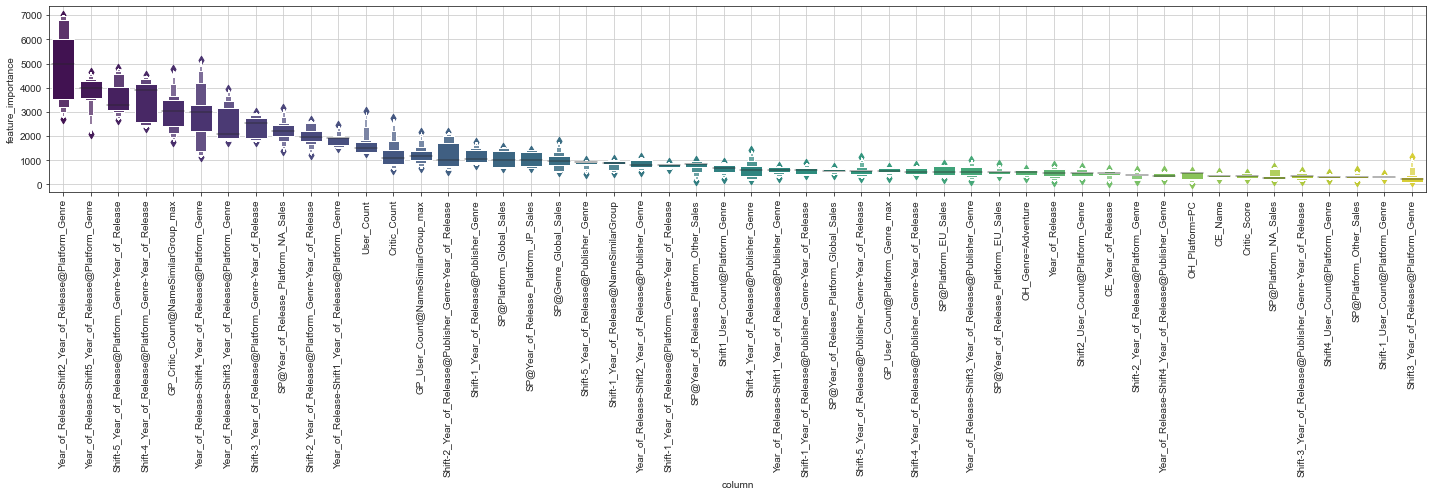

In [76]:
fig, ax = visualize_importance(models, train_feat_df)

In [77]:
pred = np.array([model.predict(test_feat_df.values) for model in models])
pred = np.mean(pred, axis=0)
pred = np.expm1(pred)
pred = np.where(pred < 0, 0, pred)
sub_df = pd.DataFrame({ 'Global_Sales': pred })
sub_df.to_csv(os.path.join(OUTPUT_DIR, f'{NOTEOOKNAME}.csv'), index=False)

Submission する前には予測値がまともかどうかちゃんと見ておきます。(貴重なsubmissionを無駄にしないため)

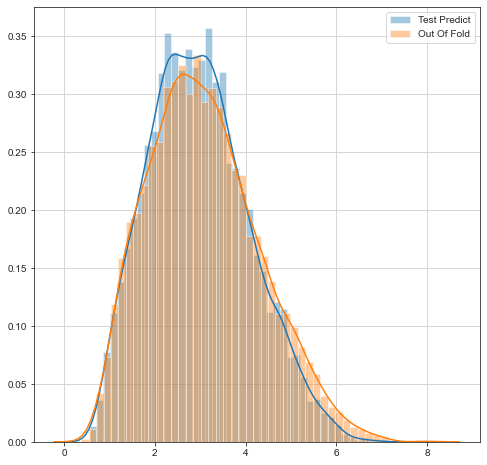

In [78]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.distplot(np.log1p(pred), label='Test Predict')
sns.distplot(oof, label='Out Of Fold')
ax.legend()
ax.grid()